In [1]:
!pip install flwr==1.3.0
!pip install -U flwr["simulation"]
!pip install ray==2.2.0
!pip install tensorflow==2.12.0
!pip install numpy==1.22.4
!pip install matplotlib==3.7.1

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
  Using cached ray-2.2.0-cp310-cp310-manylinux2014_x86_64.whl (57.4 MB)
  Using cached aiosignal-1.3.1-py3-none-any.whl (7.6 kB)
  Using cached frozenlist-1.3.3-cp310-cp310-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl (149 kB)
  Using cached virtualenv-20.21.0-py3-none-any.whl (8.7 MB)
  Using cached msgpack-1.0.5-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (316 kB)
  Using cached filelock-3.11.0-py3-none-any.whl (10.0 kB)
  Using cached opencensus-0.11.2-py2.py3-none-any.whl (128 kB)
  Using cached colorful-0.5.5-py2.py3-none-any.whl (201 kB)
  Using cached prometheus_client-0.13.1-py3-none-any.whl (57 kB)
  Using cached py_spy-0.3.14-py2.py3-none-manylinux_2_5_x86_64.manylinux1_x86_64.whl (3.0 MB)
  Using cached aiohttp_cors-0.7.0-py3-none-any.whl (27 kB)
  Using cached gpust

In [2]:
import os
# Make TensorFlow logs less verbose
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
import flwr as fl
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D,Flatten,Dense
from tensorflow.keras.optimizers import SGD
import numpy as np
import ray
from matplotlib import pyplot as plt

Matplotlib is building the font cache; this may take a moment.


In [3]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

num = 10
images = x_train[:num]
labels = y_train[:num]


11490434/11490434 [==============================] - 1s 0us/step


In [4]:
x_train=x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_train=x_train / 255.0
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)
x_test=x_test/255.0

y_train = tf.one_hot(y_train.astype(np.int32), depth=10)
y_test = tf.one_hot(y_test.astype(np.int32), depth=10)

## Treinamento local

In [5]:
def define_model(input_shape,num_classes):
  model = Sequential()
  model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=input_shape))
  model.add(MaxPool2D((2, 2)))
  model.add(Flatten())
  model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
  model.add(Dense(num_classes, activation='softmax'))
  # compile model
  opt = SGD(learning_rate=0.01, momentum=0.9)
  model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
  return model

In [8]:
input_shape = (28, 28, 1)
num_classes = 10

model = define_model(input_shape,num_classes)

batch_size = 64
epochs = 5
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_split=0.1)

Epoch 1/5
844/844 [==============================] - 22s 25ms/step - loss: 0.2116 - accuracy: 0.9359 - val_loss: 0.0837 - val_accuracy: 0.9753
Epoch 2/5
844/844 [==============================] - 19s 23ms/step - loss: 0.0772 - accuracy: 0.9769 - val_loss: 0.0562 - val_accuracy: 0.9867
Epoch 3/5
844/844 [==============================] - 20s 23ms/step - loss: 0.0521 - accuracy: 0.9847 - val_loss: 0.0567 - val_accuracy: 0.9845
Epoch 4/5
844/844 [==============================] - 18s 21ms/step - loss: 0.0373 - accuracy: 0.9892 - val_loss: 0.0492 - val_accuracy: 0.9862
Epoch 5/5
844/844 [==============================] - 18s 21ms/step - loss: 0.0286 - accuracy: 0.9919 - val_loss: 0.0515 - val_accuracy: 0.9858


In [14]:
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, model, x_train, y_train, x_test, y_test) -> None:
        self.model = model
        self.x_train = x_train
        self.y_train = y_train
        self.x_test = x_test
        self.y_test = y_test

    def get_parameters(self, config):
        return self.model.get_weights()

    def fit(self, parameters, config):
        self.model.set_weights(parameters)
        self.model.fit(self.x_train, self.y_train, epochs=1, verbose=2)
        return self.model.get_weights(), len(self.x_train), {}

    def evaluate(self, parameters, config):
        self.model.set_weights(parameters)
        loss, acc = self.model.evaluate(self.x_test, self.y_test, verbose=2)
        return loss, len(self.x_test), {"accuracy": acc}

In [13]:
def client_fn_random(cid: str) -> fl.client.Client:
    input_shape = (28, 28, 1)
    num_classes = 10
    num_clients = 10
    partition_size = 500
    

    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
    #sample_size_train = int(cid) * partition_size
    #sample_size_test = int(cid) * partition_size
    sample_size_train = int((1/num_clients)*len(x_train))
    sample_size_test = int((1/num_clients)*len(x_test))
    idx_train = np.random.choice(np.arange(len(x_train)), sample_size_train, replace=False)
    x_train = x_train[idx_train]/255.0
    y_train = y_train[idx_train]
    y_train = tf.one_hot(y_train.astype(np.int32), depth=10)
    idx_test = np.random.choice(np.arange(len(x_test)), sample_size_test, replace=False)
    x_test = x_test[idx_test]/255.0
    y_test = y_test[idx_test]
    y_test = tf.one_hot(y_test.astype(np.int32), depth=10)
    model = define_model(input_shape,num_classes)
    # Create and return client
    return FlowerClient(model, x_train, y_train, x_test, y_test)

In [11]:
def weighted_average(metrics):
    # Multiply accuracy of each client by number of examples used
    acc = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    # Aggregate and return custom metric (weighted average)
    results = {"accuracy": sum(acc) / sum(examples)}
    return results

In [ ]:
num_clients = 10

# Create FedAvg strategy
strategy = fl.server.strategy.FedAvg(
    fraction_fit=0.9,  
    fraction_evaluate=1,  
    min_fit_clients=9,  
    min_evaluate_clients=9,  
    min_available_clients=int(
        num_clients * 0.9
    ),  
    evaluate_metrics_aggregation_fn=weighted_average,
)

# Start simulation
history = fl.simulation.start_simulation(
    client_fn=client_fn_random,
    num_clients=num_clients,
    config=fl.server.ServerConfig(num_rounds=5),
    strategy=strategy,
    
)

In [17]:
#train the federated with three iterations, using 10,15,20 rounds 
#and plot the accuracy and loss for each round

num_clients = 10
num_rounds = [5,10,15,20]
histories = []

for i in num_rounds:
    strategy = fl.server.strategy.FedAvg(
        fraction_fit=0.9,  
        fraction_evaluate=1,  
        min_fit_clients=9,  
        min_evaluate_clients=9,  
        min_available_clients=int(
            num_clients * 0.9
        ),  
        evaluate_metrics_aggregation_fn=weighted_average,
    )

    # Start simulation
    history = fl.simulation.start_simulation(
        client_fn=client_fn_random,
        num_clients=num_clients,
        config=fl.server.ServerConfig(num_rounds=i),
        strategy=strategy,
        
    )
    histories.append(history)
    # #plot the accuracy and loss for each round
    # plt.figure(figsize=(10, 5))
    # plt.subplot(1, 2, 1)
    # plt.plot(history["train"]["loss"], label="train")
    # plt.plot(history["evaluate"]["loss"], label="evaluate")
    # plt.legend()
    # plt.xlabel("round")
    # plt.ylabel("loss")
    # plt.subplot(1, 2, 2)
    # plt.plot(history["train"]["accuracy"], label="train")
    # plt.plot(history["evaluate"]["accuracy"], label="evaluate")
    # plt.legend()
    # plt.xlabel("round")
    # plt.ylabel("accuracy")
    # plt.show()

INFO flwr 2023-04-11 17:37:44,599 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=5, round_timeout=None)
2023-04-11 17:37:50,373	INFO worker.py:1529 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 
INFO flwr 2023-04-11 17:37:51,947 | app.py:179 | Flower VCE: Ray initialized with resources: {'object_store_memory': 1665257472.0, 'CPU': 8.0, 'memory': 3330514944.0, 'node:192.168.113.157': 1.0}
INFO flwr 2023-04-11 17:37:51,947 | server.py:86 | Initializing global parameters
INFO flwr 2023-04-11 17:37:51,948 | server.py:270 | Requesting initial parameters from one random client
INFO flwr 2023-04-11 17:37:54,394 | server.py:274 | Received initial parameters from one random client
INFO flwr 2023-04-11 17:37:54,396 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-04-11 17:37:54,397 | server.py:101 | FL starting
DEBUG flwr 2023-04-11 17:37:54,399 | server.py:215 | fit_round 1: strategy sampled 9 clients (out of 10)


(launch_and_fit pid=79950) 188/188 - 14s - loss: 0.5027 - accuracy: 0.8417 - 14s/epoch - 72ms/step
(launch_and_fit pid=79948) 188/188 - 17s - loss: 0.5320 - accuracy: 0.8318 - 17s/epoch - 89ms/step
(launch_and_fit pid=79947) 188/188 - 19s - loss: 0.5189 - accuracy: 0.8338 - 19s/epoch - 103ms/step
(launch_and_fit pid=79949) 188/188 - 20s - loss: 0.5001 - accuracy: 0.8390 - 20s/epoch - 104ms/step
(launch_and_fit pid=79945) 188/188 - 19s - loss: 0.5063 - accuracy: 0.8453 - 19s/epoch - 103ms/step
(launch_and_fit pid=79952) 188/188 - 20s - loss: 0.5063 - accuracy: 0.8437 - 20s/epoch - 104ms/step
(launch_and_fit pid=79946) 188/188 - 20s - loss: 0.4872 - accuracy: 0.8495 - 20s/epoch - 107ms/step
(launch_and_fit pid=79951) 188/188 - 20s - loss: 0.5169 - accuracy: 0.8337 - 20s/epoch - 107ms/step


DEBUG flwr 2023-04-11 17:38:23,534 | server.py:229 | fit_round 1 received 9 results and 0 failures
WARNING flwr 2023-04-11 17:38:23,584 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-04-11 17:38:23,586 | server.py:165 | evaluate_round 1: strategy sampled 10 clients (out of 10)


(launch_and_fit pid=79950) 188/188 - 13s - loss: 0.5037 - accuracy: 0.8390 - 13s/epoch - 68ms/step
(launch_and_evaluate pid=79950) 32/32 - 1s - loss: 0.2541 - accuracy: 0.9280 - 1s/epoch - 40ms/step
(launch_and_evaluate pid=79951) 32/32 - 1s - loss: 0.2098 - accuracy: 0.9430 - 1s/epoch - 39ms/step
(launch_and_evaluate pid=79948) 32/32 - 1s - loss: 0.2763 - accuracy: 0.9270 - 1s/epoch - 41ms/step
(launch_and_evaluate pid=79947) 32/32 - 1s - loss: 0.2608 - accuracy: 0.9410 - 1s/epoch - 44ms/step
(launch_and_evaluate pid=79946) 32/32 - 1s - loss: 0.2364 - accuracy: 0.9380 - 1s/epoch - 41ms/step
(launch_and_evaluate pid=79945) 32/32 - 1s - loss: 0.2895 - accuracy: 0.9130 - 1s/epoch - 45ms/step
(launch_and_evaluate pid=79952) 32/32 - 1s - loss: 0.2841 - accuracy: 0.9230 - 1s/epoch - 45ms/step
(launch_and_evaluate pid=79949) 32/32 - 1s - loss: 0.2475 - accuracy: 0.9300 - 1s/epoch - 42ms/step


DEBUG flwr 2023-04-11 17:38:27,297 | server.py:179 | evaluate_round 1 received 10 results and 0 failures
DEBUG flwr 2023-04-11 17:38:27,298 | server.py:215 | fit_round 2: strategy sampled 9 clients (out of 10)


(launch_and_evaluate pid=79950) 32/32 - 0s - loss: 0.2719 - accuracy: 0.9250 - 401ms/epoch - 13ms/step
(launch_and_evaluate pid=79951) 32/32 - 0s - loss: 0.2283 - accuracy: 0.9360 - 411ms/epoch - 13ms/step
(launch_and_fit pid=79946) 188/188 - 18s - loss: 0.2388 - accuracy: 0.9272 - 18s/epoch - 96ms/step
(launch_and_fit pid=79945) 188/188 - 19s - loss: 0.2406 - accuracy: 0.9250 - 19s/epoch - 102ms/step
(launch_and_fit pid=79947) 188/188 - 19s - loss: 0.2330 - accuracy: 0.9265 - 19s/epoch - 102ms/step
(launch_and_fit pid=79949) 188/188 - 19s - loss: 0.2537 - accuracy: 0.9243 - 19s/epoch - 102ms/step
(launch_and_fit pid=79950) 188/188 - 20s - loss: 0.2571 - accuracy: 0.9218 - 20s/epoch - 104ms/step
(launch_and_fit pid=79948) 188/188 - 19s - loss: 0.2469 - accuracy: 0.9255 - 19s/epoch - 102ms/step
(launch_and_fit pid=79951) 188/188 - 20s - loss: 0.2570 - accuracy: 0.9222 - 20s/epoch - 105ms/step
(launch_and_fit pid=79952) 188/188 - 20s - loss: 0.2449 - accuracy: 0.9292 - 20s/epoch - 105ms/

DEBUG flwr 2023-04-11 17:38:51,443 | server.py:229 | fit_round 2 received 9 results and 0 failures
DEBUG flwr 2023-04-11 17:38:51,474 | server.py:165 | evaluate_round 2: strategy sampled 10 clients (out of 10)


(launch_and_fit pid=79949) 188/188 - 3s - loss: 0.2604 - accuracy: 0.9205 - 3s/epoch - 14ms/step
(launch_and_evaluate pid=79949) 32/32 - 1s - loss: 0.1461 - accuracy: 0.9630 - 1s/epoch - 42ms/step
(launch_and_evaluate pid=79950) 32/32 - 1s - loss: 0.1585 - accuracy: 0.9600 - 1s/epoch - 39ms/step
(launch_and_evaluate pid=79945) 32/32 - 1s - loss: 0.1319 - accuracy: 0.9640 - 1s/epoch - 37ms/step
(launch_and_evaluate pid=79951) 32/32 - 1s - loss: 0.1319 - accuracy: 0.9670 - 1s/epoch - 44ms/step
(launch_and_evaluate pid=79952) 32/32 - 1s - loss: 0.1628 - accuracy: 0.9550 - 1s/epoch - 43ms/step
(launch_and_evaluate pid=79948) 32/32 - 1s - loss: 0.1478 - accuracy: 0.9590 - 1s/epoch - 45ms/step
(launch_and_evaluate pid=79947) 32/32 - 1s - loss: 0.1488 - accuracy: 0.9630 - 1s/epoch - 44ms/step
(launch_and_evaluate pid=79946) 32/32 - 1s - loss: 0.1324 - accuracy: 0.9590 - 1s/epoch - 46ms/step


DEBUG flwr 2023-04-11 17:38:55,394 | server.py:179 | evaluate_round 2 received 10 results and 0 failures
DEBUG flwr 2023-04-11 17:38:55,394 | server.py:215 | fit_round 3: strategy sampled 9 clients (out of 10)


(launch_and_evaluate pid=79949) 32/32 - 0s - loss: 0.1460 - accuracy: 0.9610 - 381ms/epoch - 12ms/step
(launch_and_evaluate pid=79945) 32/32 - 0s - loss: 0.1520 - accuracy: 0.9610 - 407ms/epoch - 13ms/step
(launch_and_fit pid=79948) 188/188 - 17s - loss: 0.1566 - accuracy: 0.9530 - 17s/epoch - 93ms/step
(launch_and_fit pid=79947) 188/188 - 18s - loss: 0.1702 - accuracy: 0.9455 - 18s/epoch - 98ms/step
(launch_and_fit pid=79952) 188/188 - 18s - loss: 0.1877 - accuracy: 0.9428 - 18s/epoch - 98ms/step
(launch_and_fit pid=79951) 188/188 - 20s - loss: 0.1766 - accuracy: 0.9455 - 20s/epoch - 104ms/step
(launch_and_fit pid=79946) 188/188 - 19s - loss: 0.1687 - accuracy: 0.9505 - 19s/epoch - 103ms/step
(launch_and_fit pid=79950) 188/188 - 20s - loss: 0.1722 - accuracy: 0.9450 - 20s/epoch - 105ms/step
(launch_and_fit pid=79949) 188/188 - 20s - loss: 0.1727 - accuracy: 0.9487 - 20s/epoch - 106ms/step
(launch_and_fit pid=79945) 188/188 - 20s - loss: 0.1770 - accuracy: 0.9442 - 20s/epoch - 107ms/st

DEBUG flwr 2023-04-11 17:39:19,970 | server.py:229 | fit_round 3 received 9 results and 0 failures
DEBUG flwr 2023-04-11 17:39:20,014 | server.py:165 | evaluate_round 3: strategy sampled 10 clients (out of 10)


(launch_and_fit pid=79948) 188/188 - 4s - loss: 0.1681 - accuracy: 0.9498 - 4s/epoch - 20ms/step
(launch_and_evaluate pid=79949) 32/32 - 1s - loss: 0.1141 - accuracy: 0.9570 - 1s/epoch - 38ms/step
(launch_and_evaluate pid=79950) 32/32 - 1s - loss: 0.1110 - accuracy: 0.9690 - 1s/epoch - 38ms/step
(launch_and_evaluate pid=79945) 32/32 - 1s - loss: 0.1371 - accuracy: 0.9560 - 1s/epoch - 38ms/step
(launch_and_evaluate pid=79951) 32/32 - 1s - loss: 0.1056 - accuracy: 0.9690 - 1s/epoch - 39ms/step
(launch_and_evaluate pid=79948) 32/32 - 1s - loss: 0.1155 - accuracy: 0.9630 - 1s/epoch - 39ms/step
(launch_and_evaluate pid=79952) 32/32 - 2s - loss: 0.0966 - accuracy: 0.9730 - 2s/epoch - 59ms/step
(launch_and_evaluate pid=79947) 32/32 - 2s - loss: 0.1245 - accuracy: 0.9620 - 2s/epoch - 58ms/step
(launch_and_evaluate pid=79946) 32/32 - 2s - loss: 0.1061 - accuracy: 0.9680 - 2s/epoch - 59ms/step


DEBUG flwr 2023-04-11 17:39:23,903 | server.py:179 | evaluate_round 3 received 10 results and 0 failures
DEBUG flwr 2023-04-11 17:39:23,904 | server.py:215 | fit_round 4: strategy sampled 9 clients (out of 10)


(launch_and_evaluate pid=79945) 32/32 - 0s - loss: 0.1326 - accuracy: 0.9550 - 425ms/epoch - 13ms/step
(launch_and_evaluate pid=79949) 32/32 - 0s - loss: 0.1165 - accuracy: 0.9660 - 420ms/epoch - 13ms/step
(launch_and_fit pid=79949) 188/188 - 18s - loss: 0.1407 - accuracy: 0.9557 - 18s/epoch - 97ms/step
(launch_and_fit pid=79952) 188/188 - 18s - loss: 0.1312 - accuracy: 0.9597 - 18s/epoch - 97ms/step
(launch_and_fit pid=79945) 188/188 - 19s - loss: 0.1311 - accuracy: 0.9613 - 19s/epoch - 99ms/step
(launch_and_fit pid=79950) 188/188 - 18s - loss: 0.1442 - accuracy: 0.9582 - 18s/epoch - 98ms/step
(launch_and_fit pid=79946) 188/188 - 19s - loss: 0.1385 - accuracy: 0.9552 - 19s/epoch - 100ms/step
(launch_and_fit pid=79948) 188/188 - 19s - loss: 0.1283 - accuracy: 0.9608 - 19s/epoch - 103ms/step
(launch_and_fit pid=79947) 188/188 - 19s - loss: 0.1485 - accuracy: 0.9562 - 19s/epoch - 102ms/step
(launch_and_fit pid=79949) 188/188 - 3s - loss: 0.1449 - accuracy: 0.9550 - 3s/epoch - 17ms/step


(raylet) [2023-04-11 17:39:50,357 E 79857 79857] (raylet) node_manager.cc:3097: 1 Workers (tasks / actors) killed due to memory pressure (OOM), 0 Workers crashed due to other reasons at node (ID: 2b7e9e139e8d29f8cd1e0de99a269df4da0a16562129c7f852cf8209, IP: 192.168.113.157) over the last time period. To see more information about the Workers killed on this node, use `ray logs raylet.out -ip 192.168.113.157`
(raylet) 
(raylet) Refer to the documentation on how to address the out of memory issue: https://docs.ray.io/en/latest/ray-core/scheduling/ray-oom-prevention.html. Consider provisioning more memory on this node or reducing task parallelism by requesting more CPUs per task. To adjust the kill threshold, set the environment variable `RAY_memory_usage_threshold` when starting Ray. To disable worker killing, set the environment variable `RAY_memory_monitor_refresh_ms` to zero.
DEBUG flwr 2023-04-11 17:39:50,448 | server.py:229 | fit_round 4 received 9 results and 0 failures
DEBUG flwr 2

(launch_and_fit pid=81518) 188/188 - 4s - loss: 0.1248 - accuracy: 0.9627 - 4s/epoch - 19ms/step
(launch_and_evaluate pid=79947) 32/32 - 1s - loss: 0.0851 - accuracy: 0.9710 - 1s/epoch - 38ms/step
(launch_and_evaluate pid=79950) 32/32 - 1s - loss: 0.1188 - accuracy: 0.9630 - 1s/epoch - 38ms/step
(launch_and_evaluate pid=79949) 32/32 - 1s - loss: 0.0843 - accuracy: 0.9740 - 1s/epoch - 42ms/step
(launch_and_evaluate pid=79948) 32/32 - 1s - loss: 0.1162 - accuracy: 0.9630 - 1s/epoch - 42ms/step
(launch_and_evaluate pid=79945) 32/32 - 1s - loss: 0.1037 - accuracy: 0.9660 - 1s/epoch - 41ms/step
(launch_and_evaluate pid=79946) 32/32 - 1s - loss: 0.1125 - accuracy: 0.9670 - 1s/epoch - 47ms/step
(launch_and_evaluate pid=81518) 32/32 - 1s - loss: 0.0839 - accuracy: 0.9720 - 1s/epoch - 46ms/step
(launch_and_evaluate pid=79952) 32/32 - 1s - loss: 0.0956 - accuracy: 0.9660 - 1s/epoch - 43ms/step


DEBUG flwr 2023-04-11 17:39:54,308 | server.py:179 | evaluate_round 4 received 10 results and 0 failures
DEBUG flwr 2023-04-11 17:39:54,309 | server.py:215 | fit_round 5: strategy sampled 9 clients (out of 10)


(launch_and_evaluate pid=79950) 32/32 - 0s - loss: 0.0928 - accuracy: 0.9720 - 405ms/epoch - 13ms/step
(launch_and_evaluate pid=79947) 32/32 - 0s - loss: 0.0999 - accuracy: 0.9700 - 418ms/epoch - 13ms/step
(launch_and_fit pid=79952) 188/188 - 18s - loss: 0.1115 - accuracy: 0.9648 - 18s/epoch - 93ms/step
(launch_and_fit pid=79946) 188/188 - 18s - loss: 0.1111 - accuracy: 0.9680 - 18s/epoch - 96ms/step
(launch_and_fit pid=79947) 188/188 - 18s - loss: 0.1119 - accuracy: 0.9655 - 18s/epoch - 97ms/step
(launch_and_fit pid=79950) 188/188 - 19s - loss: 0.1096 - accuracy: 0.9673 - 19s/epoch - 100ms/step
(launch_and_fit pid=79948) 188/188 - 19s - loss: 0.1100 - accuracy: 0.9705 - 19s/epoch - 101ms/step
(launch_and_fit pid=81518) 188/188 - 19s - loss: 0.1201 - accuracy: 0.9638 - 19s/epoch - 103ms/step
(launch_and_fit pid=79945) 188/188 - 19s - loss: 0.1164 - accuracy: 0.9635 - 19s/epoch - 104ms/step
(launch_and_fit pid=79952) 188/188 - 3s - loss: 0.1157 - accuracy: 0.9665 - 3s/epoch - 18ms/step


DEBUG flwr 2023-04-11 17:40:22,412 | server.py:229 | fit_round 5 received 9 results and 0 failures
DEBUG flwr 2023-04-11 17:40:22,453 | server.py:165 | evaluate_round 5: strategy sampled 10 clients (out of 10)


(launch_and_fit pid=81961) 188/188 - 3s - loss: 0.1278 - accuracy: 0.9623 - 3s/epoch - 14ms/step
(launch_and_evaluate pid=79952) 32/32 - 1s - loss: 0.0865 - accuracy: 0.9730 - 1s/epoch - 40ms/step
(launch_and_evaluate pid=79945) 32/32 - 1s - loss: 0.0832 - accuracy: 0.9790 - 1s/epoch - 40ms/step
(launch_and_evaluate pid=79947) 32/32 - 1s - loss: 0.0849 - accuracy: 0.9710 - 1s/epoch - 41ms/step
(launch_and_evaluate pid=79950) 32/32 - 1s - loss: 0.0969 - accuracy: 0.9690 - 1s/epoch - 42ms/step
(launch_and_evaluate pid=79948) 32/32 - 1s - loss: 0.0725 - accuracy: 0.9740 - 1s/epoch - 41ms/step
(launch_and_evaluate pid=81518) 32/32 - 1s - loss: 0.0735 - accuracy: 0.9760 - 1s/epoch - 46ms/step
(launch_and_evaluate pid=81961) 32/32 - 1s - loss: 0.0827 - accuracy: 0.9690 - 1s/epoch - 44ms/step
(launch_and_evaluate pid=79952) 32/32 - 0s - loss: 0.0714 - accuracy: 0.9770 - 419ms/epoch - 13ms/step
(launch_and_evaluate pid=81518) 32/32 - 0s - loss: 0.0697 - accuracy: 0.9840 - 366ms/epoch - 11ms/st

DEBUG flwr 2023-04-11 17:40:29,272 | server.py:179 | evaluate_round 5 received 10 results and 0 failures
INFO flwr 2023-04-11 17:40:29,273 | server.py:144 | FL finished in 154.87414769000316
INFO flwr 2023-04-11 17:40:29,274 | app.py:202 | app_fit: losses_distributed [(1, 0.25588160902261736), (2, 0.1458265572786331), (3, 0.11594991609454156), (4, 0.09927783235907554), (5, 0.08021057471632957)]
INFO flwr 2023-04-11 17:40:29,275 | app.py:203 | app_fit: metrics_distributed {'accuracy': [(1, 0.9303999960422515), (2, 0.9611999988555908), (3, 0.9637999951839447), (4, 0.9684000074863434), (5, 0.9742999970912933)]}
INFO flwr 2023-04-11 17:40:29,276 | app.py:204 | app_fit: losses_centralized []
INFO flwr 2023-04-11 17:40:29,276 | app.py:205 | app_fit: metrics_centralized {}
INFO flwr 2023-04-11 17:40:29,280 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)
2023-04-11 17:40:34,952	INFO worker.py:1529 -- Started a local Ray instance. View the dash

(launch_and_fit pid=82551) 188/188 - 12s - loss: 0.4926 - accuracy: 0.8435 - 12s/epoch - 65ms/step
(launch_and_fit pid=82556) 188/188 - 17s - loss: 0.4925 - accuracy: 0.8458 - 17s/epoch - 92ms/step
(launch_and_fit pid=82558) 188/188 - 18s - loss: 0.4691 - accuracy: 0.8577 - 18s/epoch - 96ms/step
(launch_and_fit pid=82554) 188/188 - 19s - loss: 0.4884 - accuracy: 0.8550 - 19s/epoch - 100ms/step
(launch_and_fit pid=82552) 188/188 - 20s - loss: 0.4795 - accuracy: 0.8480 - 20s/epoch - 104ms/step
(launch_and_fit pid=82557) 188/188 - 19s - loss: 0.5045 - accuracy: 0.8418 - 19s/epoch - 104ms/step
(launch_and_fit pid=82555) 188/188 - 19s - loss: 0.4926 - accuracy: 0.8427 - 19s/epoch - 103ms/step
(launch_and_fit pid=82553) 188/188 - 20s - loss: 0.4902 - accuracy: 0.8527 - 20s/epoch - 107ms/step


DEBUG flwr 2023-04-11 17:41:07,967 | server.py:229 | fit_round 1 received 9 results and 0 failures
WARNING flwr 2023-04-11 17:41:08,014 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-04-11 17:41:08,014 | server.py:165 | evaluate_round 1: strategy sampled 10 clients (out of 10)


(launch_and_fit pid=82551) 188/188 - 14s - loss: 0.4988 - accuracy: 0.8450 - 14s/epoch - 75ms/step
(launch_and_evaluate pid=82553) 32/32 - 1s - loss: 0.2076 - accuracy: 0.9470 - 1s/epoch - 38ms/step
(launch_and_evaluate pid=82551) 32/32 - 1s - loss: 0.2342 - accuracy: 0.9320 - 1s/epoch - 44ms/step
(launch_and_evaluate pid=82557) 32/32 - 1s - loss: 0.2247 - accuracy: 0.9350 - 1s/epoch - 41ms/step
(launch_and_evaluate pid=82554) 32/32 - 1s - loss: 0.2031 - accuracy: 0.9470 - 1s/epoch - 42ms/step
(launch_and_evaluate pid=82556) 32/32 - 1s - loss: 0.2382 - accuracy: 0.9340 - 1s/epoch - 42ms/step
(launch_and_evaluate pid=82555) 32/32 - 1s - loss: 0.1915 - accuracy: 0.9470 - 1s/epoch - 45ms/step
(launch_and_evaluate pid=82552) 32/32 - 1s - loss: 0.2520 - accuracy: 0.9250 - 1s/epoch - 45ms/step
(launch_and_evaluate pid=82558) 32/32 - 2s - loss: 0.2124 - accuracy: 0.9470 - 2s/epoch - 48ms/step


DEBUG flwr 2023-04-11 17:41:11,792 | server.py:179 | evaluate_round 1 received 10 results and 0 failures
DEBUG flwr 2023-04-11 17:41:11,793 | server.py:215 | fit_round 2: strategy sampled 9 clients (out of 10)


(launch_and_evaluate pid=82553) 32/32 - 0s - loss: 0.2239 - accuracy: 0.9400 - 373ms/epoch - 12ms/step
(launch_and_evaluate pid=82557) 32/32 - 0s - loss: 0.1856 - accuracy: 0.9530 - 400ms/epoch - 13ms/step
(launch_and_fit pid=82553) 188/188 - 18s - loss: 0.2322 - accuracy: 0.9292 - 18s/epoch - 97ms/step
(launch_and_fit pid=82555) 188/188 - 18s - loss: 0.2300 - accuracy: 0.9310 - 18s/epoch - 95ms/step
(launch_and_fit pid=82556) 188/188 - 18s - loss: 0.2378 - accuracy: 0.9287 - 18s/epoch - 98ms/step
(launch_and_fit pid=82554) 188/188 - 19s - loss: 0.2260 - accuracy: 0.9310 - 19s/epoch - 99ms/step
(launch_and_fit pid=82558) 188/188 - 19s - loss: 0.2318 - accuracy: 0.9303 - 19s/epoch - 101ms/step
(launch_and_fit pid=82552) 188/188 - 19s - loss: 0.2260 - accuracy: 0.9320 - 19s/epoch - 102ms/step
(launch_and_fit pid=82557) 188/188 - 19s - loss: 0.2467 - accuracy: 0.9268 - 19s/epoch - 103ms/step
(launch_and_fit pid=82551) 188/188 - 19s - loss: 0.2277 - accuracy: 0.9330 - 19s/epoch - 104ms/ste

DEBUG flwr 2023-04-11 17:41:35,763 | server.py:229 | fit_round 2 received 9 results and 0 failures
DEBUG flwr 2023-04-11 17:41:35,811 | server.py:165 | evaluate_round 2: strategy sampled 10 clients (out of 10)


(launch_and_fit pid=82553) 188/188 - 3s - loss: 0.2463 - accuracy: 0.9267 - 3s/epoch - 15ms/step
(launch_and_evaluate pid=82551) 32/32 - 1s - loss: 0.1305 - accuracy: 0.9610 - 1s/epoch - 38ms/step
(launch_and_evaluate pid=82557) 32/32 - 1s - loss: 0.1317 - accuracy: 0.9620 - 1s/epoch - 41ms/step
(launch_and_evaluate pid=82552) 32/32 - 1s - loss: 0.1491 - accuracy: 0.9550 - 1s/epoch - 45ms/step
(launch_and_evaluate pid=82556) 32/32 - 2s - loss: 0.1482 - accuracy: 0.9580 - 2s/epoch - 48ms/step
(launch_and_evaluate pid=82555) 32/32 - 1s - loss: 0.1624 - accuracy: 0.9540 - 1s/epoch - 43ms/step
(launch_and_evaluate pid=82558) 32/32 - 1s - loss: 0.1335 - accuracy: 0.9610 - 1s/epoch - 46ms/step
(launch_and_evaluate pid=82554) 32/32 - 2s - loss: 0.1480 - accuracy: 0.9640 - 2s/epoch - 47ms/step
(launch_and_evaluate pid=82553) 32/32 - 2s - loss: 0.1335 - accuracy: 0.9600 - 2s/epoch - 58ms/step


DEBUG flwr 2023-04-11 17:41:39,614 | server.py:179 | evaluate_round 2 received 10 results and 0 failures
DEBUG flwr 2023-04-11 17:41:39,620 | server.py:215 | fit_round 3: strategy sampled 9 clients (out of 10)


(launch_and_evaluate pid=82551) 32/32 - 0s - loss: 0.1328 - accuracy: 0.9650 - 389ms/epoch - 12ms/step
(launch_and_evaluate pid=82557) 32/32 - 0s - loss: 0.1559 - accuracy: 0.9470 - 417ms/epoch - 13ms/step
(launch_and_fit pid=82558) 188/188 - 18s - loss: 0.1697 - accuracy: 0.9492 - 18s/epoch - 94ms/step
(launch_and_fit pid=82554) 188/188 - 19s - loss: 0.1530 - accuracy: 0.9553 - 19s/epoch - 99ms/step
(launch_and_fit pid=82551) 188/188 - 19s - loss: 0.1663 - accuracy: 0.9505 - 19s/epoch - 103ms/step
(launch_and_fit pid=82552) 188/188 - 19s - loss: 0.1709 - accuracy: 0.9478 - 19s/epoch - 102ms/step
(launch_and_fit pid=82556) 188/188 - 19s - loss: 0.1619 - accuracy: 0.9538 - 19s/epoch - 103ms/step
(launch_and_fit pid=82553) 188/188 - 20s - loss: 0.1634 - accuracy: 0.9527 - 20s/epoch - 107ms/step
(launch_and_fit pid=82557) 188/188 - 20s - loss: 0.1719 - accuracy: 0.9493 - 20s/epoch - 105ms/step
(launch_and_fit pid=82555) 188/188 - 20s - loss: 0.1658 - accuracy: 0.9522 - 20s/epoch - 106ms/s

DEBUG flwr 2023-04-11 17:42:04,048 | server.py:229 | fit_round 3 received 9 results and 0 failures
DEBUG flwr 2023-04-11 17:42:04,127 | server.py:165 | evaluate_round 3: strategy sampled 10 clients (out of 10)


(launch_and_fit pid=82558) 188/188 - 3s - loss: 0.1620 - accuracy: 0.9520 - 3s/epoch - 17ms/step
(launch_and_evaluate pid=82553) 32/32 - 1s - loss: 0.1022 - accuracy: 0.9740 - 1s/epoch - 40ms/step
(launch_and_evaluate pid=82557) 32/32 - 1s - loss: 0.1026 - accuracy: 0.9680 - 1s/epoch - 38ms/step
(launch_and_evaluate pid=82558) 32/32 - 1s - loss: 0.1086 - accuracy: 0.9710 - 1s/epoch - 39ms/step
(launch_and_evaluate pid=82551) 32/32 - 1s - loss: 0.1436 - accuracy: 0.9630 - 1s/epoch - 39ms/step
(launch_and_evaluate pid=82554) 32/32 - 2s - loss: 0.1245 - accuracy: 0.9670 - 2s/epoch - 62ms/step
(launch_and_evaluate pid=82556) 32/32 - 2s - loss: 0.1027 - accuracy: 0.9700 - 2s/epoch - 62ms/step
(launch_and_evaluate pid=82555) 32/32 - 2s - loss: 0.1150 - accuracy: 0.9630 - 2s/epoch - 63ms/step
(launch_and_evaluate pid=82552) 32/32 - 2s - loss: 0.0893 - accuracy: 0.9760 - 2s/epoch - 62ms/step


DEBUG flwr 2023-04-11 17:42:08,438 | server.py:179 | evaluate_round 3 received 10 results and 0 failures
DEBUG flwr 2023-04-11 17:42:08,439 | server.py:215 | fit_round 4: strategy sampled 9 clients (out of 10)


(launch_and_evaluate pid=82557) 32/32 - 0s - loss: 0.1027 - accuracy: 0.9740 - 460ms/epoch - 14ms/step
(launch_and_evaluate pid=82558) 32/32 - 0s - loss: 0.1058 - accuracy: 0.9680 - 452ms/epoch - 14ms/step
(launch_and_fit pid=82553) 188/188 - 18s - loss: 0.1388 - accuracy: 0.9563 - 18s/epoch - 96ms/step
(launch_and_fit pid=82556) 188/188 - 19s - loss: 0.1284 - accuracy: 0.9613 - 19s/epoch - 98ms/step
(launch_and_fit pid=82552) 188/188 - 19s - loss: 0.1374 - accuracy: 0.9612 - 19s/epoch - 100ms/step
(launch_and_fit pid=82554) 188/188 - 19s - loss: 0.1268 - accuracy: 0.9633 - 19s/epoch - 102ms/step
(launch_and_fit pid=82557) 188/188 - 20s - loss: 0.1276 - accuracy: 0.9622 - 20s/epoch - 104ms/step
(launch_and_fit pid=82551) 188/188 - 20s - loss: 0.1272 - accuracy: 0.9632 - 20s/epoch - 104ms/step
(launch_and_fit pid=82555) 188/188 - 20s - loss: 0.1393 - accuracy: 0.9590 - 20s/epoch - 104ms/step
(launch_and_fit pid=82558) 188/188 - 20s - loss: 0.1362 - accuracy: 0.9590 - 20s/epoch - 105ms/s

DEBUG flwr 2023-04-11 17:42:32,580 | server.py:229 | fit_round 4 received 9 results and 0 failures
DEBUG flwr 2023-04-11 17:42:32,630 | server.py:165 | evaluate_round 4: strategy sampled 10 clients (out of 10)


(launch_and_fit pid=82553) 188/188 - 3s - loss: 0.1281 - accuracy: 0.9605 - 3s/epoch - 15ms/step


(raylet) [2023-04-11 17:42:34,926 E 82435 82435] (raylet) node_manager.cc:3097: 1 Workers (tasks / actors) killed due to memory pressure (OOM), 0 Workers crashed due to other reasons at node (ID: ae95a07a17b6ec9e2ef23f7a1d059df136dcb2db189a95b4cbcf41cc, IP: 192.168.113.157) over the last time period. To see more information about the Workers killed on this node, use `ray logs raylet.out -ip 192.168.113.157`
(raylet) 
(raylet) Refer to the documentation on how to address the out of memory issue: https://docs.ray.io/en/latest/ray-core/scheduling/ray-oom-prevention.html. Consider provisioning more memory on this node or reducing task parallelism by requesting more CPUs per task. To adjust the kill threshold, set the environment variable `RAY_memory_usage_threshold` when starting Ray. To disable worker killing, set the environment variable `RAY_memory_monitor_refresh_ms` to zero.


(launch_and_evaluate pid=82551) 32/32 - 1s - loss: 0.0965 - accuracy: 0.9710 - 1s/epoch - 42ms/step
(launch_and_evaluate pid=82554) 32/32 - 2s - loss: 0.0941 - accuracy: 0.9750 - 2s/epoch - 48ms/step
(launch_and_evaluate pid=82557) 32/32 - 2s - loss: 0.0805 - accuracy: 0.9700 - 2s/epoch - 48ms/step
(launch_and_evaluate pid=82558) 32/32 - 1s - loss: 0.1184 - accuracy: 0.9620 - 1s/epoch - 42ms/step
(launch_and_evaluate pid=82553) 32/32 - 2s - loss: 0.1073 - accuracy: 0.9640 - 2s/epoch - 49ms/step
(launch_and_evaluate pid=82555) 32/32 - 2s - loss: 0.0765 - accuracy: 0.9790 - 2s/epoch - 47ms/step
(launch_and_evaluate pid=82552) 32/32 - 2s - loss: 0.0977 - accuracy: 0.9690 - 2s/epoch - 48ms/step
(launch_and_evaluate pid=82551) 32/32 - 0s - loss: 0.0895 - accuracy: 0.9690 - 463ms/epoch - 14ms/step
(launch_and_evaluate pid=82554) 32/32 - 0s - loss: 0.0841 - accuracy: 0.9770 - 462ms/epoch - 14ms/step


DEBUG flwr 2023-04-11 17:42:39,751 | server.py:179 | evaluate_round 4 received 10 results and 0 failures
DEBUG flwr 2023-04-11 17:42:39,758 | server.py:215 | fit_round 5: strategy sampled 9 clients (out of 10)


(launch_and_evaluate pid=84248) 32/32 - 0s - loss: 0.0914 - accuracy: 0.9690 - 384ms/epoch - 12ms/step
(launch_and_fit pid=82554) 188/188 - 17s - loss: 0.1202 - accuracy: 0.9637 - 17s/epoch - 92ms/step
(launch_and_fit pid=82552) 188/188 - 18s - loss: 0.1046 - accuracy: 0.9702 - 18s/epoch - 95ms/step
(launch_and_fit pid=82558) 188/188 - 18s - loss: 0.1143 - accuracy: 0.9650 - 18s/epoch - 96ms/step
(launch_and_fit pid=82555) 188/188 - 19s - loss: 0.1190 - accuracy: 0.9665 - 19s/epoch - 101ms/step
(launch_and_fit pid=82553) 188/188 - 19s - loss: 0.1061 - accuracy: 0.9665 - 19s/epoch - 103ms/step
(launch_and_fit pid=82557) 188/188 - 19s - loss: 0.1074 - accuracy: 0.9665 - 19s/epoch - 103ms/step
(launch_and_fit pid=82551) 188/188 - 20s - loss: 0.1188 - accuracy: 0.9647 - 20s/epoch - 107ms/step
(launch_and_fit pid=84248) 188/188 - 20s - loss: 0.1112 - accuracy: 0.9673 - 20s/epoch - 106ms/step


DEBUG flwr 2023-04-11 17:43:03,748 | server.py:229 | fit_round 5 received 9 results and 0 failures
DEBUG flwr 2023-04-11 17:43:03,790 | server.py:165 | evaluate_round 5: strategy sampled 10 clients (out of 10)


(launch_and_fit pid=82554) 188/188 - 3s - loss: 0.1045 - accuracy: 0.9728 - 3s/epoch - 15ms/step
(launch_and_evaluate pid=82553) 32/32 - 1s - loss: 0.0995 - accuracy: 0.9670 - 1s/epoch - 36ms/step
(launch_and_evaluate pid=82554) 32/32 - 1s - loss: 0.0856 - accuracy: 0.9760 - 1s/epoch - 37ms/step
(launch_and_evaluate pid=82555) 32/32 - 1s - loss: 0.0882 - accuracy: 0.9780 - 1s/epoch - 41ms/step
(launch_and_evaluate pid=82557) 32/32 - 1s - loss: 0.1069 - accuracy: 0.9660 - 1s/epoch - 42ms/step
(launch_and_evaluate pid=82558) 32/32 - 1s - loss: 0.0740 - accuracy: 0.9780 - 1s/epoch - 43ms/step
(launch_and_evaluate pid=84248) 32/32 - 1s - loss: 0.0699 - accuracy: 0.9790 - 1s/epoch - 42ms/step
(launch_and_evaluate pid=82551) 32/32 - 1s - loss: 0.0813 - accuracy: 0.9740 - 1s/epoch - 45ms/step
(launch_and_evaluate pid=82553) 32/32 - 0s - loss: 0.0821 - accuracy: 0.9730 - 459ms/epoch - 14ms/step
(launch_and_evaluate pid=82554) 32/32 - 0s - loss: 0.0742 - accuracy: 0.9740 - 463ms/epoch - 14ms/st

DEBUG flwr 2023-04-11 17:43:11,081 | server.py:179 | evaluate_round 5 received 10 results and 0 failures
DEBUG flwr 2023-04-11 17:43:11,082 | server.py:215 | fit_round 6: strategy sampled 9 clients (out of 10)


(launch_and_evaluate pid=84595) 32/32 - 0s - loss: 0.0734 - accuracy: 0.9780 - 416ms/epoch - 13ms/step
(launch_and_fit pid=82553) 188/188 - 17s - loss: 0.0888 - accuracy: 0.9752 - 17s/epoch - 92ms/step
(launch_and_fit pid=82557) 188/188 - 17s - loss: 0.0981 - accuracy: 0.9687 - 17s/epoch - 91ms/step
(launch_and_fit pid=84595) 188/188 - 18s - loss: 0.0987 - accuracy: 0.9712 - 18s/epoch - 96ms/step
(launch_and_fit pid=82551) 188/188 - 18s - loss: 0.1016 - accuracy: 0.9705 - 18s/epoch - 98ms/step
(launch_and_fit pid=82554) 188/188 - 18s - loss: 0.0868 - accuracy: 0.9742 - 18s/epoch - 98ms/step
(launch_and_fit pid=82558) 188/188 - 19s - loss: 0.0908 - accuracy: 0.9722 - 19s/epoch - 99ms/step
(launch_and_fit pid=84248) 188/188 - 19s - loss: 0.1046 - accuracy: 0.9702 - 19s/epoch - 99ms/step
(launch_and_fit pid=82557) 188/188 - 3s - loss: 0.0965 - accuracy: 0.9708 - 3s/epoch - 17ms/step


(raylet) [2023-04-11 17:43:34,927 E 82435 82435] (raylet) node_manager.cc:3097: 2 Workers (tasks / actors) killed due to memory pressure (OOM), 0 Workers crashed due to other reasons at node (ID: ae95a07a17b6ec9e2ef23f7a1d059df136dcb2db189a95b4cbcf41cc, IP: 192.168.113.157) over the last time period. To see more information about the Workers killed on this node, use `ray logs raylet.out -ip 192.168.113.157`
(raylet) 
(raylet) Refer to the documentation on how to address the out of memory issue: https://docs.ray.io/en/latest/ray-core/scheduling/ray-oom-prevention.html. Consider provisioning more memory on this node or reducing task parallelism by requesting more CPUs per task. To adjust the kill threshold, set the environment variable `RAY_memory_usage_threshold` when starting Ray. To disable worker killing, set the environment variable `RAY_memory_monitor_refresh_ms` to zero.
DEBUG flwr 2023-04-11 17:43:37,266 | server.py:229 | fit_round 6 received 9 results and 0 failures
DEBUG flwr 2

(launch_and_fit pid=84903) 188/188 - 3s - loss: 0.0876 - accuracy: 0.9772 - 3s/epoch - 18ms/step
(launch_and_evaluate pid=82551) 32/32 - 1s - loss: 0.0661 - accuracy: 0.9810 - 1s/epoch - 39ms/step
(launch_and_evaluate pid=84903) 32/32 - 1s - loss: 0.0940 - accuracy: 0.9650 - 1s/epoch - 41ms/step
(launch_and_evaluate pid=82554) 32/32 - 1s - loss: 0.0621 - accuracy: 0.9790 - 1s/epoch - 40ms/step
(launch_and_evaluate pid=82557) 32/32 - 1s - loss: 0.0957 - accuracy: 0.9720 - 1s/epoch - 41ms/step
(launch_and_evaluate pid=84248) 32/32 - 1s - loss: 0.0601 - accuracy: 0.9840 - 1s/epoch - 44ms/step
(launch_and_evaluate pid=82558) 32/32 - 1s - loss: 0.0809 - accuracy: 0.9760 - 1s/epoch - 44ms/step
(launch_and_evaluate pid=84595) 32/32 - 1s - loss: 0.0706 - accuracy: 0.9780 - 1s/epoch - 44ms/step
(launch_and_evaluate pid=84903) 32/32 - 0s - loss: 0.0857 - accuracy: 0.9730 - 429ms/epoch - 13ms/step
(launch_and_evaluate pid=82558) 32/32 - 0s - loss: 0.0754 - accuracy: 0.9740 - 471ms/epoch - 15ms/st

DEBUG flwr 2023-04-11 17:43:44,514 | server.py:179 | evaluate_round 6 received 10 results and 0 failures
DEBUG flwr 2023-04-11 17:43:44,515 | server.py:215 | fit_round 7: strategy sampled 9 clients (out of 10)


(launch_and_evaluate pid=85065) 32/32 - 0s - loss: 0.0965 - accuracy: 0.9750 - 415ms/epoch - 13ms/step
(launch_and_fit pid=82557) 188/188 - 17s - loss: 0.0808 - accuracy: 0.9742 - 17s/epoch - 91ms/step
(launch_and_fit pid=84903) 188/188 - 18s - loss: 0.0817 - accuracy: 0.9748 - 18s/epoch - 94ms/step
(launch_and_fit pid=82554) 188/188 - 19s - loss: 0.0939 - accuracy: 0.9720 - 19s/epoch - 101ms/step
(launch_and_fit pid=82558) 188/188 - 19s - loss: 0.0919 - accuracy: 0.9728 - 19s/epoch - 101ms/step
(launch_and_fit pid=84595) 188/188 - 19s - loss: 0.0820 - accuracy: 0.9735 - 19s/epoch - 103ms/step
(launch_and_fit pid=84248) 188/188 - 20s - loss: 0.0857 - accuracy: 0.9735 - 20s/epoch - 104ms/step
(launch_and_fit pid=85065) 188/188 - 19s - loss: 0.0794 - accuracy: 0.9748 - 19s/epoch - 102ms/step
(launch_and_fit pid=82557) 188/188 - 4s - loss: 0.0891 - accuracy: 0.9718 - 4s/epoch - 20ms/step


DEBUG flwr 2023-04-11 17:44:12,168 | server.py:229 | fit_round 7 received 9 results and 0 failures
DEBUG flwr 2023-04-11 17:44:12,231 | server.py:165 | evaluate_round 7: strategy sampled 10 clients (out of 10)


(launch_and_fit pid=85372) 188/188 - 3s - loss: 0.0885 - accuracy: 0.9737 - 3s/epoch - 14ms/step
(launch_and_evaluate pid=82554) 32/32 - 1s - loss: 0.0948 - accuracy: 0.9740 - 1s/epoch - 34ms/step
(launch_and_evaluate pid=84595) 32/32 - 1s - loss: 0.0675 - accuracy: 0.9840 - 1s/epoch - 38ms/step
(launch_and_evaluate pid=82557) 32/32 - 1s - loss: 0.0628 - accuracy: 0.9800 - 1s/epoch - 43ms/step
(launch_and_evaluate pid=85065) 32/32 - 1s - loss: 0.0817 - accuracy: 0.9730 - 1s/epoch - 43ms/step
(launch_and_evaluate pid=84248) 32/32 - 1s - loss: 0.0888 - accuracy: 0.9740 - 1s/epoch - 44ms/step
(launch_and_evaluate pid=85372) 32/32 - 1s - loss: 0.0536 - accuracy: 0.9820 - 1s/epoch - 44ms/step
(launch_and_evaluate pid=82558) 32/32 - 1s - loss: 0.0691 - accuracy: 0.9820 - 1s/epoch - 43ms/step
(launch_and_evaluate pid=84595) 32/32 - 0s - loss: 0.0619 - accuracy: 0.9800 - 443ms/epoch - 14ms/step
(launch_and_evaluate pid=82558) 32/32 - 0s - loss: 0.0631 - accuracy: 0.9760 - 379ms/epoch - 12ms/st

DEBUG flwr 2023-04-11 17:44:18,987 | server.py:179 | evaluate_round 7 received 10 results and 0 failures
DEBUG flwr 2023-04-11 17:44:18,989 | server.py:215 | fit_round 8: strategy sampled 9 clients (out of 10)


(launch_and_evaluate pid=85518) 32/32 - 0s - loss: 0.0563 - accuracy: 0.9830 - 398ms/epoch - 12ms/step


(raylet) [2023-04-11 17:44:34,933 E 82435 82435] (raylet) node_manager.cc:3097: 4 Workers (tasks / actors) killed due to memory pressure (OOM), 0 Workers crashed due to other reasons at node (ID: ae95a07a17b6ec9e2ef23f7a1d059df136dcb2db189a95b4cbcf41cc, IP: 192.168.113.157) over the last time period. To see more information about the Workers killed on this node, use `ray logs raylet.out -ip 192.168.113.157`
(raylet) 
(raylet) Refer to the documentation on how to address the out of memory issue: https://docs.ray.io/en/latest/ray-core/scheduling/ray-oom-prevention.html. Consider provisioning more memory on this node or reducing task parallelism by requesting more CPUs per task. To adjust the kill threshold, set the environment variable `RAY_memory_usage_threshold` when starting Ray. To disable worker killing, set the environment variable `RAY_memory_monitor_refresh_ms` to zero.


(launch_and_fit pid=84248) 188/188 - 18s - loss: 0.0845 - accuracy: 0.9758 - 18s/epoch - 93ms/step
(launch_and_fit pid=82558) 188/188 - 18s - loss: 0.0807 - accuracy: 0.9755 - 18s/epoch - 97ms/step
(launch_and_fit pid=84595) 188/188 - 18s - loss: 0.0855 - accuracy: 0.9728 - 18s/epoch - 95ms/step
(launch_and_fit pid=85065) 188/188 - 18s - loss: 0.0719 - accuracy: 0.9802 - 18s/epoch - 98ms/step
(launch_and_fit pid=85372) 188/188 - 19s - loss: 0.0726 - accuracy: 0.9773 - 19s/epoch - 100ms/step
(launch_and_fit pid=85518) 188/188 - 19s - loss: 0.0785 - accuracy: 0.9768 - 19s/epoch - 101ms/step
(launch_and_fit pid=82557) 188/188 - 19s - loss: 0.0799 - accuracy: 0.9775 - 19s/epoch - 102ms/step
(launch_and_fit pid=84248) 188/188 - 3s - loss: 0.0813 - accuracy: 0.9753 - 3s/epoch - 17ms/step


DEBUG flwr 2023-04-11 17:44:45,926 | server.py:229 | fit_round 8 received 9 results and 0 failures
DEBUG flwr 2023-04-11 17:44:45,965 | server.py:165 | evaluate_round 8: strategy sampled 10 clients (out of 10)


(launch_and_fit pid=85801) 188/188 - 3s - loss: 0.0758 - accuracy: 0.9792 - 3s/epoch - 14ms/step
(launch_and_evaluate pid=85372) 32/32 - 1s - loss: 0.0524 - accuracy: 0.9800 - 1s/epoch - 36ms/step
(launch_and_evaluate pid=82557) 32/32 - 1s - loss: 0.0799 - accuracy: 0.9710 - 1s/epoch - 38ms/step
(launch_and_evaluate pid=84248) 32/32 - 1s - loss: 0.0512 - accuracy: 0.9860 - 1s/epoch - 42ms/step
(launch_and_evaluate pid=85065) 32/32 - 1s - loss: 0.0584 - accuracy: 0.9790 - 1s/epoch - 41ms/step
(launch_and_evaluate pid=84595) 32/32 - 1s - loss: 0.0647 - accuracy: 0.9820 - 1s/epoch - 46ms/step
(launch_and_evaluate pid=85518) 32/32 - 1s - loss: 0.0947 - accuracy: 0.9670 - 1s/epoch - 46ms/step
(launch_and_evaluate pid=85801) 32/32 - 1s - loss: 0.0495 - accuracy: 0.9850 - 1s/epoch - 43ms/step
(launch_and_evaluate pid=85372) 32/32 - 0s - loss: 0.0474 - accuracy: 0.9870 - 354ms/epoch - 11ms/step
(launch_and_evaluate pid=85801) 32/32 - 0s - loss: 0.0624 - accuracy: 0.9840 - 366ms/epoch - 11ms/st

DEBUG flwr 2023-04-11 17:44:52,851 | server.py:179 | evaluate_round 8 received 10 results and 0 failures
DEBUG flwr 2023-04-11 17:44:52,851 | server.py:215 | fit_round 9: strategy sampled 9 clients (out of 10)


(launch_and_evaluate pid=86016) 32/32 - 0s - loss: 0.0606 - accuracy: 0.9810 - 418ms/epoch - 13ms/step
(launch_and_fit pid=84248) 188/188 - 18s - loss: 0.0748 - accuracy: 0.9773 - 18s/epoch - 96ms/step
(launch_and_fit pid=85801) 188/188 - 18s - loss: 0.0710 - accuracy: 0.9793 - 18s/epoch - 97ms/step
(launch_and_fit pid=82557) 188/188 - 19s - loss: 0.0789 - accuracy: 0.9768 - 19s/epoch - 100ms/step
(launch_and_fit pid=85518) 188/188 - 19s - loss: 0.0761 - accuracy: 0.9793 - 19s/epoch - 103ms/step
(launch_and_fit pid=85372) 188/188 - 19s - loss: 0.0671 - accuracy: 0.9818 - 19s/epoch - 103ms/step
(launch_and_fit pid=84595) 188/188 - 20s - loss: 0.0824 - accuracy: 0.9753 - 20s/epoch - 104ms/step
(launch_and_fit pid=85065) 188/188 - 20s - loss: 0.0652 - accuracy: 0.9793 - 20s/epoch - 104ms/step
(launch_and_fit pid=86016) 188/188 - 20s - loss: 0.0636 - accuracy: 0.9807 - 20s/epoch - 105ms/step


DEBUG flwr 2023-04-11 17:45:17,043 | server.py:229 | fit_round 9 received 9 results and 0 failures
DEBUG flwr 2023-04-11 17:45:17,081 | server.py:165 | evaluate_round 9: strategy sampled 10 clients (out of 10)


(launch_and_fit pid=84248) 188/188 - 3s - loss: 0.0690 - accuracy: 0.9805 - 3s/epoch - 14ms/step
(launch_and_evaluate pid=84248) 32/32 - 1s - loss: 0.0753 - accuracy: 0.9790 - 1s/epoch - 37ms/step
(launch_and_evaluate pid=85065) 32/32 - 1s - loss: 0.0334 - accuracy: 0.9910 - 1s/epoch - 42ms/step
(launch_and_evaluate pid=84595) 32/32 - 1s - loss: 0.0643 - accuracy: 0.9820 - 1s/epoch - 44ms/step
(launch_and_evaluate pid=85372) 32/32 - 1s - loss: 0.0674 - accuracy: 0.9800 - 1s/epoch - 40ms/step
(launch_and_evaluate pid=85518) 32/32 - 1s - loss: 0.0638 - accuracy: 0.9790 - 1s/epoch - 46ms/step
(launch_and_evaluate pid=86016) 32/32 - 2s - loss: 0.0728 - accuracy: 0.9770 - 2s/epoch - 51ms/step
(launch_and_evaluate pid=82557) 32/32 - 1s - loss: 0.0574 - accuracy: 0.9820 - 1s/epoch - 46ms/step
(launch_and_evaluate pid=84248) 32/32 - 0s - loss: 0.0534 - accuracy: 0.9850 - 452ms/epoch - 14ms/step
(launch_and_evaluate pid=85065) 32/32 - 0s - loss: 0.0540 - accuracy: 0.9840 - 457ms/epoch - 14ms/st

DEBUG flwr 2023-04-11 17:45:24,042 | server.py:179 | evaluate_round 9 received 10 results and 0 failures
DEBUG flwr 2023-04-11 17:45:24,043 | server.py:215 | fit_round 10: strategy sampled 9 clients (out of 10)


(launch_and_evaluate pid=86326) 32/32 - 0s - loss: 0.0472 - accuracy: 0.9890 - 390ms/epoch - 12ms/step


(raylet) [2023-04-11 17:45:34,935 E 82435 82435] (raylet) node_manager.cc:3097: 3 Workers (tasks / actors) killed due to memory pressure (OOM), 0 Workers crashed due to other reasons at node (ID: ae95a07a17b6ec9e2ef23f7a1d059df136dcb2db189a95b4cbcf41cc, IP: 192.168.113.157) over the last time period. To see more information about the Workers killed on this node, use `ray logs raylet.out -ip 192.168.113.157`
(raylet) 
(raylet) Refer to the documentation on how to address the out of memory issue: https://docs.ray.io/en/latest/ray-core/scheduling/ray-oom-prevention.html. Consider provisioning more memory on this node or reducing task parallelism by requesting more CPUs per task. To adjust the kill threshold, set the environment variable `RAY_memory_usage_threshold` when starting Ray. To disable worker killing, set the environment variable `RAY_memory_monitor_refresh_ms` to zero.


(launch_and_fit pid=85065) 188/188 - 18s - loss: 0.0597 - accuracy: 0.9822 - 18s/epoch - 93ms/step
(launch_and_fit pid=84248) 188/188 - 18s - loss: 0.0743 - accuracy: 0.9787 - 18s/epoch - 94ms/step
(launch_and_fit pid=86016) 188/188 - 18s - loss: 0.0586 - accuracy: 0.9835 - 18s/epoch - 98ms/step
(launch_and_fit pid=86326) 188/188 - 18s - loss: 0.0595 - accuracy: 0.9818 - 18s/epoch - 98ms/step
(launch_and_fit pid=85372) 188/188 - 19s - loss: 0.0579 - accuracy: 0.9808 - 19s/epoch - 99ms/step
(launch_and_fit pid=85518) 188/188 - 19s - loss: 0.0658 - accuracy: 0.9803 - 19s/epoch - 100ms/step
(launch_and_fit pid=82557) 188/188 - 19s - loss: 0.0758 - accuracy: 0.9783 - 19s/epoch - 102ms/step
(launch_and_fit pid=85065) 188/188 - 4s - loss: 0.0570 - accuracy: 0.9835 - 4s/epoch - 20ms/step


DEBUG flwr 2023-04-11 17:45:50,275 | server.py:229 | fit_round 10 received 9 results and 0 failures
DEBUG flwr 2023-04-11 17:45:50,315 | server.py:165 | evaluate_round 10: strategy sampled 10 clients (out of 10)


(launch_and_fit pid=86602) 188/188 - 4s - loss: 0.0692 - accuracy: 0.9795 - 4s/epoch - 23ms/step
(launch_and_evaluate pid=82557) 32/32 - 1s - loss: 0.0606 - accuracy: 0.9790 - 1s/epoch - 47ms/step
(launch_and_evaluate pid=86016) 32/32 - 1s - loss: 0.0481 - accuracy: 0.9860 - 1s/epoch - 37ms/step
(launch_and_evaluate pid=86602) 32/32 - 2s - loss: 0.0467 - accuracy: 0.9830 - 2s/epoch - 47ms/step
(launch_and_evaluate pid=85065) 32/32 - 1s - loss: 0.0529 - accuracy: 0.9800 - 1s/epoch - 41ms/step
(launch_and_evaluate pid=85372) 32/32 - 1s - loss: 0.0588 - accuracy: 0.9820 - 1s/epoch - 43ms/step
(launch_and_evaluate pid=85518) 32/32 - 1s - loss: 0.0637 - accuracy: 0.9740 - 1s/epoch - 46ms/step
(launch_and_evaluate pid=86326) 32/32 - 1s - loss: 0.0560 - accuracy: 0.9780 - 1s/epoch - 41ms/step
(launch_and_evaluate pid=82557) 32/32 - 0s - loss: 0.0536 - accuracy: 0.9830 - 464ms/epoch - 14ms/step
(launch_and_evaluate pid=85372) 32/32 - 0s - loss: 0.0418 - accuracy: 0.9830 - 373ms/epoch - 12ms/st

DEBUG flwr 2023-04-11 17:45:57,371 | server.py:179 | evaluate_round 10 received 10 results and 0 failures
INFO flwr 2023-04-11 17:45:57,371 | server.py:144 | FL finished in 318.37512711699674
INFO flwr 2023-04-11 17:45:57,372 | app.py:202 | app_fit: losses_distributed [(1, 0.2173346295952797), (2, 0.1425639197230339), (3, 0.10970798954367637), (4, 0.09359264299273491), (5, 0.08350019678473472), (6, 0.07870225049555302), (7, 0.069973374158144), (8, 0.062120475247502326), (9, 0.0588942252099514), (10, 0.05373464524745941)]
INFO flwr 2023-04-11 17:45:57,372 | app.py:203 | app_fit: metrics_distributed {'accuracy': [(1, 0.9407000124454499), (2, 0.9587000012397766), (3, 0.9694000005722045), (4, 0.9704999983310699), (5, 0.9742999911308289), (6, 0.9756999969482422), (7, 0.9787999987602234), (8, 0.9802000045776367), (9, 0.9828000009059906), (10, 0.9807999908924103)]}
INFO flwr 2023-04-11 17:45:57,373 | app.py:204 | app_fit: losses_centralized []
INFO flwr 2023-04-11 17:45:57,373 | app.py:205 | 

(launch_and_fit pid=87227) 188/188 - 13s - loss: 0.4868 - accuracy: 0.8503 - 13s/epoch - 70ms/step
(launch_and_fit pid=87228) 188/188 - 18s - loss: 0.4922 - accuracy: 0.8435 - 18s/epoch - 98ms/step
(launch_and_fit pid=87230) 188/188 - 18s - loss: 0.5088 - accuracy: 0.8350 - 18s/epoch - 98ms/step
(launch_and_fit pid=87234) 188/188 - 19s - loss: 0.5296 - accuracy: 0.8362 - 19s/epoch - 102ms/step
(launch_and_fit pid=87231) 188/188 - 19s - loss: 0.4819 - accuracy: 0.8463 - 19s/epoch - 103ms/step
(launch_and_fit pid=87229) 188/188 - 19s - loss: 0.4968 - accuracy: 0.8447 - 19s/epoch - 104ms/step
(launch_and_fit pid=87233) 188/188 - 19s - loss: 0.5002 - accuracy: 0.8450 - 19s/epoch - 104ms/step
(launch_and_fit pid=87232) 188/188 - 20s - loss: 0.5236 - accuracy: 0.8343 - 20s/epoch - 106ms/step


DEBUG flwr 2023-04-11 17:46:35,543 | server.py:229 | fit_round 1 received 9 results and 0 failures
WARNING flwr 2023-04-11 17:46:35,597 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-04-11 17:46:35,597 | server.py:165 | evaluate_round 1: strategy sampled 10 clients (out of 10)


(launch_and_fit pid=87227) 188/188 - 13s - loss: 0.4927 - accuracy: 0.8447 - 13s/epoch - 69ms/step
(launch_and_evaluate pid=87227) 32/32 - 1s - loss: 0.2325 - accuracy: 0.9360 - 1s/epoch - 45ms/step
(launch_and_evaluate pid=87233) 32/32 - 1s - loss: 0.2388 - accuracy: 0.9290 - 1s/epoch - 43ms/step
(launch_and_evaluate pid=87231) 32/32 - 1s - loss: 0.2504 - accuracy: 0.9250 - 1s/epoch - 45ms/step
(launch_and_evaluate pid=87228) 32/32 - 2s - loss: 0.2451 - accuracy: 0.9310 - 2s/epoch - 49ms/step
(launch_and_evaluate pid=87232) 32/32 - 1s - loss: 0.2196 - accuracy: 0.9430 - 1s/epoch - 47ms/step
(launch_and_evaluate pid=87234) 32/32 - 1s - loss: 0.2324 - accuracy: 0.9300 - 1s/epoch - 46ms/step
(launch_and_evaluate pid=87229) 32/32 - 2s - loss: 0.2437 - accuracy: 0.9330 - 2s/epoch - 47ms/step
(launch_and_evaluate pid=87230) 32/32 - 1s - loss: 0.2517 - accuracy: 0.9330 - 1s/epoch - 44ms/step


DEBUG flwr 2023-04-11 17:46:39,463 | server.py:179 | evaluate_round 1 received 10 results and 0 failures
DEBUG flwr 2023-04-11 17:46:39,463 | server.py:215 | fit_round 2: strategy sampled 9 clients (out of 10)


(launch_and_evaluate pid=87227) 32/32 - 0s - loss: 0.2203 - accuracy: 0.9410 - 425ms/epoch - 13ms/step
(launch_and_evaluate pid=87233) 32/32 - 0s - loss: 0.2704 - accuracy: 0.9160 - 432ms/epoch - 14ms/step
(launch_and_fit pid=87230) 188/188 - 18s - loss: 0.2504 - accuracy: 0.9235 - 18s/epoch - 97ms/step
(launch_and_fit pid=87233) 188/188 - 19s - loss: 0.2495 - accuracy: 0.9267 - 19s/epoch - 99ms/step
(launch_and_fit pid=87229) 188/188 - 19s - loss: 0.2245 - accuracy: 0.9280 - 19s/epoch - 101ms/step
(launch_and_fit pid=87234) 188/188 - 19s - loss: 0.2463 - accuracy: 0.9262 - 19s/epoch - 104ms/step
(launch_and_fit pid=87231) 188/188 - 19s - loss: 0.2404 - accuracy: 0.9255 - 19s/epoch - 103ms/step
(launch_and_fit pid=87232) 188/188 - 20s - loss: 0.2409 - accuracy: 0.9260 - 20s/epoch - 104ms/step
(launch_and_fit pid=87227) 188/188 - 20s - loss: 0.2403 - accuracy: 0.9298 - 20s/epoch - 106ms/step
(launch_and_fit pid=87228) 188/188 - 20s - loss: 0.2597 - accuracy: 0.9220 - 20s/epoch - 105ms/s

DEBUG flwr 2023-04-11 17:47:03,563 | server.py:229 | fit_round 2 received 9 results and 0 failures
DEBUG flwr 2023-04-11 17:47:03,603 | server.py:165 | evaluate_round 2: strategy sampled 10 clients (out of 10)


(launch_and_fit pid=87233) 188/188 - 3s - loss: 0.2479 - accuracy: 0.9242 - 3s/epoch - 14ms/step
(launch_and_evaluate pid=87234) 32/32 - 1s - loss: 0.1377 - accuracy: 0.9560 - 1s/epoch - 35ms/step
(launch_and_evaluate pid=87231) 32/32 - 1s - loss: 0.1574 - accuracy: 0.9500 - 1s/epoch - 40ms/step
(launch_and_evaluate pid=87230) 32/32 - 1s - loss: 0.1381 - accuracy: 0.9590 - 1s/epoch - 39ms/step
(launch_and_evaluate pid=87232) 32/32 - 1s - loss: 0.1252 - accuracy: 0.9660 - 1s/epoch - 45ms/step
(launch_and_evaluate pid=87228) 32/32 - 1s - loss: 0.1595 - accuracy: 0.9540 - 1s/epoch - 45ms/step
(launch_and_evaluate pid=87227) 32/32 - 1s - loss: 0.1426 - accuracy: 0.9570 - 1s/epoch - 45ms/step
(launch_and_evaluate pid=87229) 32/32 - 1s - loss: 0.1366 - accuracy: 0.9600 - 1s/epoch - 45ms/step
(launch_and_evaluate pid=87233) 32/32 - 2s - loss: 0.1704 - accuracy: 0.9520 - 2s/epoch - 54ms/step


DEBUG flwr 2023-04-11 17:47:07,363 | server.py:179 | evaluate_round 2 received 10 results and 0 failures
DEBUG flwr 2023-04-11 17:47:07,363 | server.py:215 | fit_round 3: strategy sampled 9 clients (out of 10)


(launch_and_evaluate pid=87234) 32/32 - 0s - loss: 0.1600 - accuracy: 0.9540 - 411ms/epoch - 13ms/step
(launch_and_evaluate pid=87230) 32/32 - 0s - loss: 0.1781 - accuracy: 0.9470 - 414ms/epoch - 13ms/step
(launch_and_fit pid=87228) 188/188 - 18s - loss: 0.1800 - accuracy: 0.9460 - 18s/epoch - 97ms/step
(launch_and_fit pid=87233) 188/188 - 20s - loss: 0.1648 - accuracy: 0.9522 - 20s/epoch - 104ms/step
(launch_and_fit pid=87229) 188/188 - 19s - loss: 0.1807 - accuracy: 0.9472 - 19s/epoch - 103ms/step
(launch_and_fit pid=87230) 188/188 - 20s - loss: 0.1732 - accuracy: 0.9482 - 20s/epoch - 105ms/step
(launch_and_fit pid=87231) 188/188 - 20s - loss: 0.1699 - accuracy: 0.9512 - 20s/epoch - 106ms/step
(launch_and_fit pid=87232) 188/188 - 20s - loss: 0.1696 - accuracy: 0.9522 - 20s/epoch - 105ms/step
(launch_and_fit pid=87234) 188/188 - 20s - loss: 0.1667 - accuracy: 0.9523 - 20s/epoch - 106ms/step
(launch_and_fit pid=87227) 188/188 - 20s - loss: 0.1819 - accuracy: 0.9475 - 20s/epoch - 108ms/

DEBUG flwr 2023-04-11 17:47:32,456 | server.py:229 | fit_round 3 received 9 results and 0 failures
DEBUG flwr 2023-04-11 17:47:32,495 | server.py:165 | evaluate_round 3: strategy sampled 10 clients (out of 10)


(launch_and_fit pid=87228) 188/188 - 3s - loss: 0.1729 - accuracy: 0.9490 - 3s/epoch - 17ms/step
(launch_and_evaluate pid=87227) 32/32 - 1s - loss: 0.1276 - accuracy: 0.9620 - 1s/epoch - 40ms/step
(launch_and_evaluate pid=87228) 32/32 - 1s - loss: 0.0981 - accuracy: 0.9690 - 1s/epoch - 39ms/step
(launch_and_evaluate pid=87234) 32/32 - 1s - loss: 0.1263 - accuracy: 0.9630 - 1s/epoch - 45ms/step
(launch_and_evaluate pid=87233) 32/32 - 1s - loss: 0.1184 - accuracy: 0.9630 - 1s/epoch - 45ms/step
(launch_and_evaluate pid=87230) 32/32 - 1s - loss: 0.1247 - accuracy: 0.9620 - 1s/epoch - 45ms/step
(launch_and_evaluate pid=87232) 32/32 - 2s - loss: 0.1297 - accuracy: 0.9710 - 2s/epoch - 60ms/step
(launch_and_evaluate pid=87229) 32/32 - 2s - loss: 0.1255 - accuracy: 0.9630 - 2s/epoch - 67ms/step
(launch_and_evaluate pid=87231) 32/32 - 2s - loss: 0.1113 - accuracy: 0.9640 - 2s/epoch - 67ms/step


DEBUG flwr 2023-04-11 17:47:36,967 | server.py:179 | evaluate_round 3 received 10 results and 0 failures
DEBUG flwr 2023-04-11 17:47:36,968 | server.py:215 | fit_round 4: strategy sampled 9 clients (out of 10)


(launch_and_evaluate pid=87228) 32/32 - 0s - loss: 0.1059 - accuracy: 0.9670 - 440ms/epoch - 14ms/step
(launch_and_evaluate pid=87234) 32/32 - 0s - loss: 0.1300 - accuracy: 0.9600 - 439ms/epoch - 14ms/step
(launch_and_fit pid=87231) 188/188 - 19s - loss: 0.1541 - accuracy: 0.9542 - 19s/epoch - 100ms/step
(launch_and_fit pid=87233) 188/188 - 19s - loss: 0.1386 - accuracy: 0.9578 - 19s/epoch - 100ms/step
(launch_and_fit pid=87229) 188/188 - 20s - loss: 0.1305 - accuracy: 0.9613 - 20s/epoch - 106ms/step
(launch_and_fit pid=87227) 188/188 - 20s - loss: 0.1484 - accuracy: 0.9550 - 20s/epoch - 105ms/step
(launch_and_fit pid=87232) 188/188 - 20s - loss: 0.1452 - accuracy: 0.9560 - 20s/epoch - 108ms/step
(launch_and_fit pid=87230) 188/188 - 20s - loss: 0.1446 - accuracy: 0.9560 - 20s/epoch - 109ms/step
(launch_and_fit pid=87234) 188/188 - 21s - loss: 0.1457 - accuracy: 0.9563 - 21s/epoch - 110ms/step
(launch_and_fit pid=87228) 188/188 - 21s - loss: 0.1312 - accuracy: 0.9623 - 21s/epoch - 110ms

DEBUG flwr 2023-04-11 17:48:02,352 | server.py:229 | fit_round 4 received 9 results and 0 failures
DEBUG flwr 2023-04-11 17:48:02,407 | server.py:165 | evaluate_round 4: strategy sampled 10 clients (out of 10)


(launch_and_fit pid=87231) 188/188 - 3s - loss: 0.1423 - accuracy: 0.9570 - 3s/epoch - 15ms/step
(launch_and_evaluate pid=87231) 32/32 - 1s - loss: 0.0788 - accuracy: 0.9770 - 1s/epoch - 42ms/step
(launch_and_evaluate pid=87230) 32/32 - 1s - loss: 0.1048 - accuracy: 0.9640 - 1s/epoch - 35ms/step
(launch_and_evaluate pid=87228) 32/32 - 1s - loss: 0.0996 - accuracy: 0.9740 - 1s/epoch - 43ms/step
(launch_and_evaluate pid=87227) 32/32 - 1s - loss: 0.1039 - accuracy: 0.9700 - 1s/epoch - 43ms/step
(launch_and_evaluate pid=87232) 32/32 - 2s - loss: 0.0848 - accuracy: 0.9800 - 2s/epoch - 50ms/step
(launch_and_evaluate pid=87234) 32/32 - 1s - loss: 0.0874 - accuracy: 0.9760 - 1s/epoch - 43ms/step
(launch_and_evaluate pid=87229) 32/32 - 1s - loss: 0.0912 - accuracy: 0.9730 - 1s/epoch - 46ms/step
(launch_and_evaluate pid=87231) 32/32 - 1s - loss: 0.0944 - accuracy: 0.9710 - 502ms/epoch - 16ms/step
(launch_and_evaluate pid=87232) 32/32 - 0s - loss: 0.0910 - accuracy: 0.9800 - 387ms/epoch - 12ms/st

DEBUG flwr 2023-04-11 17:48:09,534 | server.py:179 | evaluate_round 4 received 10 results and 0 failures
DEBUG flwr 2023-04-11 17:48:09,534 | server.py:215 | fit_round 5: strategy sampled 9 clients (out of 10)


(launch_and_evaluate pid=88958) 32/32 - 0s - loss: 0.0950 - accuracy: 0.9730 - 402ms/epoch - 13ms/step
(launch_and_fit pid=87229) 188/188 - 18s - loss: 0.1058 - accuracy: 0.9677 - 18s/epoch - 96ms/step
(launch_and_fit pid=87232) 188/188 - 19s - loss: 0.1124 - accuracy: 0.9642 - 19s/epoch - 99ms/step
(launch_and_fit pid=87231) 188/188 - 19s - loss: 0.1247 - accuracy: 0.9608 - 19s/epoch - 101ms/step
(launch_and_fit pid=87228) 188/188 - 19s - loss: 0.1073 - accuracy: 0.9690 - 19s/epoch - 100ms/step
(launch_and_fit pid=87227) 188/188 - 19s - loss: 0.1161 - accuracy: 0.9658 - 19s/epoch - 102ms/step
(launch_and_fit pid=88958) 188/188 - 20s - loss: 0.1259 - accuracy: 0.9638 - 20s/epoch - 106ms/step
(launch_and_fit pid=87234) 188/188 - 20s - loss: 0.1075 - accuracy: 0.9698 - 20s/epoch - 104ms/step
(launch_and_fit pid=87229) 188/188 - 3s - loss: 0.1161 - accuracy: 0.9655 - 3s/epoch - 18ms/step


DEBUG flwr 2023-04-11 17:48:37,914 | server.py:229 | fit_round 5 received 9 results and 0 failures
DEBUG flwr 2023-04-11 17:48:37,957 | server.py:165 | evaluate_round 5: strategy sampled 10 clients (out of 10)


(launch_and_fit pid=89222) 188/188 - 3s - loss: 0.1173 - accuracy: 0.9663 - 3s/epoch - 14ms/step
(launch_and_evaluate pid=87231) 32/32 - 1s - loss: 0.1006 - accuracy: 0.9710 - 1s/epoch - 39ms/step
(launch_and_evaluate pid=87228) 32/32 - 1s - loss: 0.0660 - accuracy: 0.9810 - 1s/epoch - 40ms/step
(launch_and_evaluate pid=87234) 32/32 - 1s - loss: 0.0868 - accuracy: 0.9680 - 1s/epoch - 39ms/step
(launch_and_evaluate pid=89222) 32/32 - 1s - loss: 0.0975 - accuracy: 0.9740 - 1s/epoch - 44ms/step
(launch_and_evaluate pid=87232) 32/32 - 1s - loss: 0.0825 - accuracy: 0.9720 - 1s/epoch - 41ms/step
(launch_and_evaluate pid=87229) 32/32 - 1s - loss: 0.0763 - accuracy: 0.9740 - 1s/epoch - 44ms/step
(launch_and_evaluate pid=88958) 32/32 - 1s - loss: 0.0945 - accuracy: 0.9670 - 1s/epoch - 45ms/step
(launch_and_evaluate pid=87227) 32/32 - 1s - loss: 0.0792 - accuracy: 0.9790 - 1s/epoch - 39ms/step


DEBUG flwr 2023-04-11 17:48:41,870 | server.py:179 | evaluate_round 5 received 10 results and 0 failures
DEBUG flwr 2023-04-11 17:48:41,872 | server.py:215 | fit_round 6: strategy sampled 9 clients (out of 10)


(launch_and_evaluate pid=87234) 32/32 - 0s - loss: 0.0623 - accuracy: 0.9840 - 401ms/epoch - 13ms/step
(launch_and_evaluate pid=89222) 32/32 - 0s - loss: 0.0897 - accuracy: 0.9730 - 415ms/epoch - 13ms/step
(launch_and_fit pid=89222) 188/188 - 16s - loss: 0.0999 - accuracy: 0.9712 - 16s/epoch - 87ms/step
(launch_and_fit pid=87228) 188/188 - 17s - loss: 0.1034 - accuracy: 0.9688 - 17s/epoch - 90ms/step
(launch_and_fit pid=87232) 188/188 - 18s - loss: 0.0901 - accuracy: 0.9715 - 18s/epoch - 95ms/step
(launch_and_fit pid=88958) 188/188 - 18s - loss: 0.0913 - accuracy: 0.9703 - 18s/epoch - 96ms/step
(launch_and_fit pid=87234) 188/188 - 18s - loss: 0.0908 - accuracy: 0.9730 - 18s/epoch - 96ms/step
(launch_and_fit pid=87229) 188/188 - 18s - loss: 0.0924 - accuracy: 0.9740 - 18s/epoch - 98ms/step
(launch_and_fit pid=87227) 188/188 - 18s - loss: 0.0997 - accuracy: 0.9700 - 18s/epoch - 98ms/step


(raylet) [2023-04-11 17:49:02,306 E 87139 87139] (raylet) node_manager.cc:3097: 3 Workers (tasks / actors) killed due to memory pressure (OOM), 0 Workers crashed due to other reasons at node (ID: 044d52f6788707d4bce6e44a1c5a7bddd9bd6902be29ac35b6ba2dcc, IP: 192.168.113.157) over the last time period. To see more information about the Workers killed on this node, use `ray logs raylet.out -ip 192.168.113.157`
(raylet) 
(raylet) Refer to the documentation on how to address the out of memory issue: https://docs.ray.io/en/latest/ray-core/scheduling/ray-oom-prevention.html. Consider provisioning more memory on this node or reducing task parallelism by requesting more CPUs per task. To adjust the kill threshold, set the environment variable `RAY_memory_usage_threshold` when starting Ray. To disable worker killing, set the environment variable `RAY_memory_monitor_refresh_ms` to zero.


(launch_and_fit pid=89222) 188/188 - 4s - loss: 0.0956 - accuracy: 0.9735 - 4s/epoch - 20ms/step


DEBUG flwr 2023-04-11 17:49:07,484 | server.py:229 | fit_round 6 received 9 results and 0 failures
DEBUG flwr 2023-04-11 17:49:07,530 | server.py:165 | evaluate_round 6: strategy sampled 10 clients (out of 10)


(launch_and_fit pid=89591) 188/188 - 4s - loss: 0.0975 - accuracy: 0.9708 - 4s/epoch - 21ms/step
(launch_and_evaluate pid=87227) 32/32 - 1s - loss: 0.0804 - accuracy: 0.9750 - 1s/epoch - 46ms/step
(launch_and_evaluate pid=87234) 32/32 - 2s - loss: 0.0687 - accuracy: 0.9770 - 2s/epoch - 51ms/step
(launch_and_evaluate pid=88958) 32/32 - 2s - loss: 0.0923 - accuracy: 0.9720 - 2s/epoch - 51ms/step
(launch_and_evaluate pid=89591) 32/32 - 2s - loss: 0.0607 - accuracy: 0.9820 - 2s/epoch - 51ms/step
(launch_and_evaluate pid=87232) 32/32 - 2s - loss: 0.0806 - accuracy: 0.9730 - 2s/epoch - 50ms/step
(launch_and_evaluate pid=87229) 32/32 - 2s - loss: 0.0959 - accuracy: 0.9700 - 2s/epoch - 56ms/step
(launch_and_evaluate pid=89222) 32/32 - 2s - loss: 0.0564 - accuracy: 0.9870 - 2s/epoch - 63ms/step
(launch_and_evaluate pid=87227) 32/32 - 0s - loss: 0.0544 - accuracy: 0.9810 - 425ms/epoch - 13ms/step
(launch_and_evaluate pid=88958) 32/32 - 0s - loss: 0.0837 - accuracy: 0.9700 - 473ms/epoch - 15ms/st

DEBUG flwr 2023-04-11 17:49:14,936 | server.py:179 | evaluate_round 6 received 10 results and 0 failures
DEBUG flwr 2023-04-11 17:49:14,937 | server.py:215 | fit_round 7: strategy sampled 9 clients (out of 10)


(launch_and_evaluate pid=89745) 32/32 - 0s - loss: 0.0738 - accuracy: 0.9760 - 384ms/epoch - 12ms/step
(launch_and_fit pid=87227) 188/188 - 19s - loss: 0.0803 - accuracy: 0.9768 - 19s/epoch - 101ms/step
(launch_and_fit pid=89222) 188/188 - 19s - loss: 0.0748 - accuracy: 0.9778 - 19s/epoch - 100ms/step
(launch_and_fit pid=89591) 188/188 - 19s - loss: 0.0822 - accuracy: 0.9755 - 19s/epoch - 102ms/step
(launch_and_fit pid=87232) 188/188 - 19s - loss: 0.0910 - accuracy: 0.9720 - 19s/epoch - 103ms/step
(launch_and_fit pid=89745) 188/188 - 19s - loss: 0.0904 - accuracy: 0.9725 - 19s/epoch - 104ms/step
(launch_and_fit pid=87229) 188/188 - 20s - loss: 0.0917 - accuracy: 0.9712 - 20s/epoch - 104ms/step
(launch_and_fit pid=88958) 188/188 - 19s - loss: 0.0827 - accuracy: 0.9743 - 19s/epoch - 102ms/step
(launch_and_fit pid=89222) 188/188 - 3s - loss: 0.0862 - accuracy: 0.9743 - 3s/epoch - 16ms/step


DEBUG flwr 2023-04-11 17:49:43,463 | server.py:229 | fit_round 7 received 9 results and 0 failures
DEBUG flwr 2023-04-11 17:49:43,506 | server.py:165 | evaluate_round 7: strategy sampled 10 clients (out of 10)


(launch_and_fit pid=90054) 188/188 - 3s - loss: 0.0911 - accuracy: 0.9728 - 3s/epoch - 14ms/step
(launch_and_evaluate pid=87227) 32/32 - 1s - loss: 0.0527 - accuracy: 0.9820 - 1s/epoch - 37ms/step
(launch_and_evaluate pid=87232) 32/32 - 1s - loss: 0.0568 - accuracy: 0.9820 - 1s/epoch - 37ms/step
(launch_and_evaluate pid=87229) 32/32 - 1s - loss: 0.0783 - accuracy: 0.9740 - 1s/epoch - 38ms/step
(launch_and_evaluate pid=90054) 32/32 - 1s - loss: 0.0673 - accuracy: 0.9800 - 1s/epoch - 42ms/step
(launch_and_evaluate pid=88958) 32/32 - 1s - loss: 0.0734 - accuracy: 0.9750 - 1s/epoch - 43ms/step
(launch_and_evaluate pid=89222) 32/32 - 1s - loss: 0.0684 - accuracy: 0.9810 - 1s/epoch - 44ms/step
(launch_and_evaluate pid=89591) 32/32 - 1s - loss: 0.0530 - accuracy: 0.9830 - 1s/epoch - 44ms/step
(launch_and_evaluate pid=89745) 32/32 - 1s - loss: 0.0746 - accuracy: 0.9750 - 1s/epoch - 44ms/step


DEBUG flwr 2023-04-11 17:49:47,266 | server.py:179 | evaluate_round 7 received 10 results and 0 failures
DEBUG flwr 2023-04-11 17:49:47,267 | server.py:215 | fit_round 8: strategy sampled 9 clients (out of 10)


(launch_and_evaluate pid=87232) 32/32 - 0s - loss: 0.0838 - accuracy: 0.9680 - 400ms/epoch - 13ms/step
(launch_and_evaluate pid=87227) 32/32 - 0s - loss: 0.0630 - accuracy: 0.9840 - 405ms/epoch - 13ms/step


(raylet) [2023-04-11 17:50:02,307 E 87139 87139] (raylet) node_manager.cc:3097: 3 Workers (tasks / actors) killed due to memory pressure (OOM), 0 Workers crashed due to other reasons at node (ID: 044d52f6788707d4bce6e44a1c5a7bddd9bd6902be29ac35b6ba2dcc, IP: 192.168.113.157) over the last time period. To see more information about the Workers killed on this node, use `ray logs raylet.out -ip 192.168.113.157`
(raylet) 
(raylet) Refer to the documentation on how to address the out of memory issue: https://docs.ray.io/en/latest/ray-core/scheduling/ray-oom-prevention.html. Consider provisioning more memory on this node or reducing task parallelism by requesting more CPUs per task. To adjust the kill threshold, set the environment variable `RAY_memory_usage_threshold` when starting Ray. To disable worker killing, set the environment variable `RAY_memory_monitor_refresh_ms` to zero.


(launch_and_fit pid=90054) 188/188 - 17s - loss: 0.0770 - accuracy: 0.9777 - 17s/epoch - 90ms/step
(launch_and_fit pid=87232) 188/188 - 17s - loss: 0.0767 - accuracy: 0.9775 - 17s/epoch - 93ms/step
(launch_and_fit pid=88958) 188/188 - 17s - loss: 0.0735 - accuracy: 0.9792 - 17s/epoch - 93ms/step
(launch_and_fit pid=89745) 188/188 - 18s - loss: 0.0811 - accuracy: 0.9747 - 18s/epoch - 96ms/step
(launch_and_fit pid=87227) 188/188 - 18s - loss: 0.0730 - accuracy: 0.9765 - 18s/epoch - 97ms/step
(launch_and_fit pid=89222) 188/188 - 18s - loss: 0.0780 - accuracy: 0.9765 - 18s/epoch - 97ms/step
(launch_and_fit pid=89591) 188/188 - 18s - loss: 0.0858 - accuracy: 0.9740 - 18s/epoch - 97ms/step
(launch_and_fit pid=90054) 188/188 - 3s - loss: 0.0703 - accuracy: 0.9788 - 3s/epoch - 18ms/step


DEBUG flwr 2023-04-11 17:50:12,749 | server.py:229 | fit_round 8 received 9 results and 0 failures
DEBUG flwr 2023-04-11 17:50:12,794 | server.py:165 | evaluate_round 8: strategy sampled 10 clients (out of 10)


(launch_and_fit pid=90408) 188/188 - 4s - loss: 0.0797 - accuracy: 0.9765 - 4s/epoch - 23ms/step
(launch_and_evaluate pid=88958) 32/32 - 1s - loss: 0.0792 - accuracy: 0.9700 - 1s/epoch - 39ms/step
(launch_and_evaluate pid=90408) 32/32 - 1s - loss: 0.0720 - accuracy: 0.9750 - 1s/epoch - 39ms/step
(launch_and_evaluate pid=89222) 32/32 - 1s - loss: 0.0742 - accuracy: 0.9770 - 1s/epoch - 42ms/step
(launch_and_evaluate pid=89745) 32/32 - 1s - loss: 0.0674 - accuracy: 0.9780 - 1s/epoch - 43ms/step
(launch_and_evaluate pid=90054) 32/32 - 1s - loss: 0.0624 - accuracy: 0.9800 - 1s/epoch - 41ms/step
(launch_and_evaluate pid=87227) 32/32 - 1s - loss: 0.0635 - accuracy: 0.9820 - 1s/epoch - 46ms/step
(launch_and_evaluate pid=89591) 32/32 - 2s - loss: 0.0648 - accuracy: 0.9800 - 2s/epoch - 52ms/step
(launch_and_evaluate pid=88958) 32/32 - 0s - loss: 0.0760 - accuracy: 0.9720 - 477ms/epoch - 15ms/step
(launch_and_evaluate pid=87227) 32/32 - 0s - loss: 0.0742 - accuracy: 0.9740 - 491ms/epoch - 15ms/st

DEBUG flwr 2023-04-11 17:50:20,218 | server.py:179 | evaluate_round 8 received 10 results and 0 failures
DEBUG flwr 2023-04-11 17:50:20,219 | server.py:215 | fit_round 9: strategy sampled 9 clients (out of 10)


(launch_and_evaluate pid=90580) 32/32 - 0s - loss: 0.0766 - accuracy: 0.9770 - 392ms/epoch - 12ms/step
(launch_and_fit pid=90054) 188/188 - 19s - loss: 0.0689 - accuracy: 0.9802 - 19s/epoch - 99ms/step
(launch_and_fit pid=90580) 188/188 - 19s - loss: 0.0790 - accuracy: 0.9753 - 19s/epoch - 100ms/step
(launch_and_fit pid=87227) 188/188 - 19s - loss: 0.0734 - accuracy: 0.9783 - 19s/epoch - 101ms/step
(launch_and_fit pid=89745) 188/188 - 19s - loss: 0.0665 - accuracy: 0.9788 - 19s/epoch - 100ms/step
(launch_and_fit pid=88958) 188/188 - 19s - loss: 0.0696 - accuracy: 0.9783 - 19s/epoch - 103ms/step
(launch_and_fit pid=89591) 188/188 - 19s - loss: 0.0675 - accuracy: 0.9807 - 19s/epoch - 102ms/step
(launch_and_fit pid=89222) 188/188 - 19s - loss: 0.0747 - accuracy: 0.9792 - 19s/epoch - 103ms/step
(launch_and_fit pid=90054) 188/188 - 3s - loss: 0.0656 - accuracy: 0.9803 - 3s/epoch - 18ms/step


DEBUG flwr 2023-04-11 17:50:48,570 | server.py:229 | fit_round 9 received 9 results and 0 failures
DEBUG flwr 2023-04-11 17:50:48,622 | server.py:165 | evaluate_round 9: strategy sampled 10 clients (out of 10)


(launch_and_fit pid=90888) 188/188 - 3s - loss: 0.0708 - accuracy: 0.9807 - 3s/epoch - 14ms/step
(launch_and_evaluate pid=88958) 32/32 - 1s - loss: 0.0449 - accuracy: 0.9880 - 1s/epoch - 44ms/step
(launch_and_evaluate pid=89222) 32/32 - 2s - loss: 0.0590 - accuracy: 0.9810 - 2s/epoch - 51ms/step
(launch_and_evaluate pid=89745) 32/32 - 2s - loss: 0.0599 - accuracy: 0.9850 - 2s/epoch - 54ms/step
(launch_and_evaluate pid=90054) 32/32 - 2s - loss: 0.0613 - accuracy: 0.9790 - 2s/epoch - 51ms/step
(launch_and_evaluate pid=90888) 32/32 - 2s - loss: 0.0658 - accuracy: 0.9820 - 2s/epoch - 50ms/step
(launch_and_evaluate pid=87227) 32/32 - 2s - loss: 0.0729 - accuracy: 0.9790 - 2s/epoch - 51ms/step
(launch_and_evaluate pid=89591) 32/32 - 1s - loss: 0.0408 - accuracy: 0.9870 - 1s/epoch - 45ms/step
(launch_and_evaluate pid=88958) 32/32 - 0s - loss: 0.0665 - accuracy: 0.9770 - 476ms/epoch - 15ms/step
(launch_and_evaluate pid=89591) 32/32 - 0s - loss: 0.0549 - accuracy: 0.9830 - 468ms/epoch - 15ms/st

DEBUG flwr 2023-04-11 17:50:55,978 | server.py:179 | evaluate_round 9 received 10 results and 0 failures
DEBUG flwr 2023-04-11 17:50:55,979 | server.py:215 | fit_round 10: strategy sampled 9 clients (out of 10)


(launch_and_evaluate pid=91053) 32/32 - 0s - loss: 0.0498 - accuracy: 0.9850 - 384ms/epoch - 12ms/step


(raylet) [2023-04-11 17:51:02,310 E 87139 87139] (raylet) node_manager.cc:3097: 4 Workers (tasks / actors) killed due to memory pressure (OOM), 0 Workers crashed due to other reasons at node (ID: 044d52f6788707d4bce6e44a1c5a7bddd9bd6902be29ac35b6ba2dcc, IP: 192.168.113.157) over the last time period. To see more information about the Workers killed on this node, use `ray logs raylet.out -ip 192.168.113.157`
(raylet) 
(raylet) Refer to the documentation on how to address the out of memory issue: https://docs.ray.io/en/latest/ray-core/scheduling/ray-oom-prevention.html. Consider provisioning more memory on this node or reducing task parallelism by requesting more CPUs per task. To adjust the kill threshold, set the environment variable `RAY_memory_usage_threshold` when starting Ray. To disable worker killing, set the environment variable `RAY_memory_monitor_refresh_ms` to zero.


(launch_and_fit pid=89591) 188/188 - 18s - loss: 0.0675 - accuracy: 0.9810 - 18s/epoch - 94ms/step
(launch_and_fit pid=88958) 188/188 - 18s - loss: 0.0603 - accuracy: 0.9820 - 18s/epoch - 95ms/step
(launch_and_fit pid=89745) 188/188 - 18s - loss: 0.0656 - accuracy: 0.9820 - 18s/epoch - 95ms/step
(launch_and_fit pid=90888) 188/188 - 18s - loss: 0.0716 - accuracy: 0.9783 - 18s/epoch - 97ms/step
(launch_and_fit pid=87227) 188/188 - 18s - loss: 0.0649 - accuracy: 0.9798 - 18s/epoch - 98ms/step
(launch_and_fit pid=91053) 188/188 - 18s - loss: 0.0590 - accuracy: 0.9825 - 18s/epoch - 98ms/step
(launch_and_fit pid=89222) 188/188 - 19s - loss: 0.0606 - accuracy: 0.9805 - 19s/epoch - 99ms/step
(launch_and_fit pid=89591) 188/188 - 3s - loss: 0.0739 - accuracy: 0.9763 - 3s/epoch - 18ms/step


DEBUG flwr 2023-04-11 17:51:22,004 | server.py:229 | fit_round 10 received 9 results and 0 failures
DEBUG flwr 2023-04-11 17:51:22,079 | server.py:165 | evaluate_round 10: strategy sampled 10 clients (out of 10)


(launch_and_fit pid=91259) 188/188 - 4s - loss: 0.0673 - accuracy: 0.9818 - 4s/epoch - 21ms/step
(launch_and_evaluate pid=89222) 32/32 - 1s - loss: 0.0391 - accuracy: 0.9890 - 1s/epoch - 41ms/step
(launch_and_evaluate pid=89591) 32/32 - 1s - loss: 0.0508 - accuracy: 0.9870 - 1s/epoch - 45ms/step
(launch_and_evaluate pid=91053) 32/32 - 1s - loss: 0.0546 - accuracy: 0.9820 - 1s/epoch - 46ms/step
(launch_and_evaluate pid=89745) 32/32 - 1s - loss: 0.0391 - accuracy: 0.9880 - 1s/epoch - 45ms/step
(launch_and_evaluate pid=90888) 32/32 - 2s - loss: 0.0338 - accuracy: 0.9910 - 2s/epoch - 48ms/step
(launch_and_evaluate pid=91259) 32/32 - 2s - loss: 0.0635 - accuracy: 0.9790 - 2s/epoch - 51ms/step
(launch_and_evaluate pid=87227) 32/32 - 2s - loss: 0.0637 - accuracy: 0.9830 - 2s/epoch - 68ms/step
(launch_and_evaluate pid=89222) 32/32 - 1s - loss: 0.0719 - accuracy: 0.9810 - 626ms/epoch - 20ms/step
(launch_and_evaluate pid=89591) 32/32 - 1s - loss: 0.0505 - accuracy: 0.9850 - 581ms/epoch - 18ms/st

DEBUG flwr 2023-04-11 17:51:29,463 | server.py:179 | evaluate_round 10 received 10 results and 0 failures
DEBUG flwr 2023-04-11 17:51:29,463 | server.py:215 | fit_round 11: strategy sampled 9 clients (out of 10)


(launch_and_evaluate pid=91467) 32/32 - 0s - loss: 0.0908 - accuracy: 0.9720 - 376ms/epoch - 12ms/step
(launch_and_fit pid=87227) 188/188 - 17s - loss: 0.0583 - accuracy: 0.9825 - 17s/epoch - 91ms/step
(launch_and_fit pid=89745) 188/188 - 17s - loss: 0.0609 - accuracy: 0.9823 - 17s/epoch - 93ms/step
(launch_and_fit pid=91259) 188/188 - 18s - loss: 0.0607 - accuracy: 0.9807 - 18s/epoch - 97ms/step
(launch_and_fit pid=91467) 188/188 - 18s - loss: 0.0686 - accuracy: 0.9797 - 18s/epoch - 98ms/step
(launch_and_fit pid=89222) 188/188 - 18s - loss: 0.0581 - accuracy: 0.9833 - 18s/epoch - 98ms/step
(launch_and_fit pid=89591) 188/188 - 19s - loss: 0.0566 - accuracy: 0.9842 - 19s/epoch - 100ms/step
(launch_and_fit pid=90888) 188/188 - 18s - loss: 0.0601 - accuracy: 0.9832 - 18s/epoch - 97ms/step
(launch_and_fit pid=87227) 188/188 - 4s - loss: 0.0580 - accuracy: 0.9833 - 4s/epoch - 21ms/step


DEBUG flwr 2023-04-11 17:51:55,882 | server.py:229 | fit_round 11 received 9 results and 0 failures
DEBUG flwr 2023-04-11 17:51:55,928 | server.py:165 | evaluate_round 11: strategy sampled 10 clients (out of 10)


(launch_and_fit pid=91733) 188/188 - 4s - loss: 0.0621 - accuracy: 0.9820 - 4s/epoch - 23ms/step
(launch_and_evaluate pid=87227) 32/32 - 1s - loss: 0.0636 - accuracy: 0.9830 - 1s/epoch - 40ms/step
(launch_and_evaluate pid=89222) 32/32 - 1s - loss: 0.0514 - accuracy: 0.9830 - 1s/epoch - 40ms/step
(launch_and_evaluate pid=91259) 32/32 - 1s - loss: 0.0534 - accuracy: 0.9820 - 1s/epoch - 40ms/step
(launch_and_evaluate pid=91733) 32/32 - 1s - loss: 0.0563 - accuracy: 0.9800 - 1s/epoch - 41ms/step
(launch_and_evaluate pid=89591) 32/32 - 1s - loss: 0.0513 - accuracy: 0.9840 - 1s/epoch - 43ms/step
(launch_and_evaluate pid=91467) 32/32 - 1s - loss: 0.0779 - accuracy: 0.9780 - 1s/epoch - 40ms/step
(launch_and_evaluate pid=90888) 32/32 - 2s - loss: 0.0425 - accuracy: 0.9890 - 2s/epoch - 52ms/step
(launch_and_evaluate pid=89222) 32/32 - 0s - loss: 0.0488 - accuracy: 0.9840 - 459ms/epoch - 14ms/step
(launch_and_evaluate pid=91733) 32/32 - 1s - loss: 0.0541 - accuracy: 0.9820 - 539ms/epoch - 17ms/st

(raylet) [2023-04-11 17:52:02,311 E 87139 87139] (raylet) node_manager.cc:3097: 3 Workers (tasks / actors) killed due to memory pressure (OOM), 0 Workers crashed due to other reasons at node (ID: 044d52f6788707d4bce6e44a1c5a7bddd9bd6902be29ac35b6ba2dcc, IP: 192.168.113.157) over the last time period. To see more information about the Workers killed on this node, use `ray logs raylet.out -ip 192.168.113.157`
(raylet) 
(raylet) Refer to the documentation on how to address the out of memory issue: https://docs.ray.io/en/latest/ray-core/scheduling/ray-oom-prevention.html. Consider provisioning more memory on this node or reducing task parallelism by requesting more CPUs per task. To adjust the kill threshold, set the environment variable `RAY_memory_usage_threshold` when starting Ray. To disable worker killing, set the environment variable `RAY_memory_monitor_refresh_ms` to zero.
DEBUG flwr 2023-04-11 17:52:03,616 | server.py:179 | evaluate_round 11 received 10 results and 0 failures
DEBUG

(launch_and_evaluate pid=91926) 32/32 - 0s - loss: 0.0781 - accuracy: 0.9770 - 414ms/epoch - 13ms/step
(launch_and_fit pid=91926) 188/188 - 17s - loss: 0.0565 - accuracy: 0.9835 - 17s/epoch - 90ms/step
(launch_and_fit pid=91733) 188/188 - 17s - loss: 0.0570 - accuracy: 0.9835 - 17s/epoch - 93ms/step
(launch_and_fit pid=91467) 188/188 - 18s - loss: 0.0578 - accuracy: 0.9838 - 18s/epoch - 97ms/step
(launch_and_fit pid=90888) 188/188 - 18s - loss: 0.0540 - accuracy: 0.9832 - 18s/epoch - 98ms/step
(launch_and_fit pid=87227) 188/188 - 19s - loss: 0.0570 - accuracy: 0.9835 - 19s/epoch - 99ms/step
(launch_and_fit pid=89591) 188/188 - 18s - loss: 0.0578 - accuracy: 0.9798 - 18s/epoch - 98ms/step
(launch_and_fit pid=89222) 188/188 - 19s - loss: 0.0621 - accuracy: 0.9830 - 19s/epoch - 98ms/step
(launch_and_fit pid=92153) 188/188 - 5s - loss: 0.0599 - accuracy: 0.9810 - 5s/epoch - 27ms/step


DEBUG flwr 2023-04-11 17:52:34,384 | server.py:229 | fit_round 12 received 9 results and 0 failures
DEBUG flwr 2023-04-11 17:52:34,432 | server.py:165 | evaluate_round 12: strategy sampled 10 clients (out of 10)


(launch_and_fit pid=92153) 188/188 - 3s - loss: 0.0613 - accuracy: 0.9833 - 3s/epoch - 14ms/step
(launch_and_evaluate pid=92153) 32/32 - 2s - loss: 0.0450 - accuracy: 0.9880 - 2s/epoch - 52ms/step
(launch_and_evaluate pid=89222) 32/32 - 1s - loss: 0.0432 - accuracy: 0.9880 - 1s/epoch - 40ms/step
(launch_and_evaluate pid=89591) 32/32 - 1s - loss: 0.0450 - accuracy: 0.9840 - 1s/epoch - 40ms/step
(launch_and_evaluate pid=91467) 32/32 - 1s - loss: 0.0475 - accuracy: 0.9840 - 1s/epoch - 45ms/step
(launch_and_evaluate pid=87227) 32/32 - 1s - loss: 0.0435 - accuracy: 0.9880 - 1s/epoch - 44ms/step
(launch_and_evaluate pid=90888) 32/32 - 1s - loss: 0.0506 - accuracy: 0.9840 - 1s/epoch - 42ms/step
(launch_and_evaluate pid=92153) 32/32 - 1s - loss: 0.0530 - accuracy: 0.9820 - 624ms/epoch - 19ms/step
(launch_and_evaluate pid=90888) 32/32 - 0s - loss: 0.0464 - accuracy: 0.9820 - 446ms/epoch - 14ms/step


DEBUG flwr 2023-04-11 17:52:42,069 | server.py:179 | evaluate_round 12 received 10 results and 0 failures
DEBUG flwr 2023-04-11 17:52:42,070 | server.py:215 | fit_round 13: strategy sampled 9 clients (out of 10)


(launch_and_evaluate pid=92357) 32/32 - 1s - loss: 0.0541 - accuracy: 0.9810 - 501ms/epoch - 16ms/step
(launch_and_evaluate pid=92438) 32/32 - 0s - loss: 0.0435 - accuracy: 0.9870 - 496ms/epoch - 15ms/step
(launch_and_fit pid=90888) 188/188 - 17s - loss: 0.0549 - accuracy: 0.9830 - 17s/epoch - 88ms/step
(launch_and_fit pid=87227) 188/188 - 18s - loss: 0.0539 - accuracy: 0.9855 - 18s/epoch - 94ms/step
(launch_and_fit pid=89222) 188/188 - 18s - loss: 0.0619 - accuracy: 0.9810 - 18s/epoch - 94ms/step
(launch_and_fit pid=92357) 188/188 - 18s - loss: 0.0548 - accuracy: 0.9840 - 18s/epoch - 95ms/step
(launch_and_fit pid=92153) 188/188 - 18s - loss: 0.0462 - accuracy: 0.9868 - 18s/epoch - 95ms/step
(launch_and_fit pid=91467) 188/188 - 18s - loss: 0.0533 - accuracy: 0.9832 - 18s/epoch - 96ms/step
(launch_and_fit pid=92438) 188/188 - 18s - loss: 0.0520 - accuracy: 0.9848 - 18s/epoch - 97ms/step


(raylet) [2023-04-11 17:53:02,312 E 87139 87139] (raylet) node_manager.cc:3097: 4 Workers (tasks / actors) killed due to memory pressure (OOM), 0 Workers crashed due to other reasons at node (ID: 044d52f6788707d4bce6e44a1c5a7bddd9bd6902be29ac35b6ba2dcc, IP: 192.168.113.157) over the last time period. To see more information about the Workers killed on this node, use `ray logs raylet.out -ip 192.168.113.157`
(raylet) 
(raylet) Refer to the documentation on how to address the out of memory issue: https://docs.ray.io/en/latest/ray-core/scheduling/ray-oom-prevention.html. Consider provisioning more memory on this node or reducing task parallelism by requesting more CPUs per task. To adjust the kill threshold, set the environment variable `RAY_memory_usage_threshold` when starting Ray. To disable worker killing, set the environment variable `RAY_memory_monitor_refresh_ms` to zero.


(launch_and_fit pid=90888) 188/188 - 3s - loss: 0.0539 - accuracy: 0.9847 - 3s/epoch - 17ms/step


DEBUG flwr 2023-04-11 17:53:08,017 | server.py:229 | fit_round 13 received 9 results and 0 failures
DEBUG flwr 2023-04-11 17:53:08,060 | server.py:165 | evaluate_round 13: strategy sampled 10 clients (out of 10)


(launch_and_fit pid=92716) 188/188 - 4s - loss: 0.0560 - accuracy: 0.9848 - 4s/epoch - 19ms/step
(launch_and_evaluate pid=89222) 32/32 - 1s - loss: 0.0565 - accuracy: 0.9860 - 1s/epoch - 45ms/step
(launch_and_evaluate pid=90888) 32/32 - 2s - loss: 0.0611 - accuracy: 0.9790 - 2s/epoch - 52ms/step
(launch_and_evaluate pid=92153) 32/32 - 2s - loss: 0.0504 - accuracy: 0.9830 - 2s/epoch - 51ms/step
(launch_and_evaluate pid=92357) 32/32 - 2s - loss: 0.0522 - accuracy: 0.9790 - 2s/epoch - 51ms/step
(launch_and_evaluate pid=92716) 32/32 - 2s - loss: 0.0553 - accuracy: 0.9770 - 2s/epoch - 52ms/step
(launch_and_evaluate pid=91467) 32/32 - 2s - loss: 0.0440 - accuracy: 0.9850 - 2s/epoch - 54ms/step
(launch_and_evaluate pid=92438) 32/32 - 2s - loss: 0.0538 - accuracy: 0.9820 - 2s/epoch - 52ms/step
(launch_and_evaluate pid=89222) 32/32 - 0s - loss: 0.0558 - accuracy: 0.9860 - 444ms/epoch - 14ms/step
(launch_and_evaluate pid=92153) 32/32 - 0s - loss: 0.0373 - accuracy: 0.9890 - 481ms/epoch - 15ms/st

DEBUG flwr 2023-04-11 17:53:15,413 | server.py:179 | evaluate_round 13 received 10 results and 0 failures
DEBUG flwr 2023-04-11 17:53:15,414 | server.py:215 | fit_round 14: strategy sampled 9 clients (out of 10)


(launch_and_evaluate pid=92919) 32/32 - 0s - loss: 0.0471 - accuracy: 0.9890 - 439ms/epoch - 14ms/step
(launch_and_fit pid=92438) 188/188 - 18s - loss: 0.0502 - accuracy: 0.9847 - 18s/epoch - 98ms/step
(launch_and_fit pid=92716) 188/188 - 18s - loss: 0.0525 - accuracy: 0.9847 - 18s/epoch - 98ms/step
(launch_and_fit pid=91467) 188/188 - 19s - loss: 0.0490 - accuracy: 0.9858 - 19s/epoch - 99ms/step
(launch_and_fit pid=92919) 188/188 - 19s - loss: 0.0513 - accuracy: 0.9847 - 19s/epoch - 99ms/step
(launch_and_fit pid=90888) 188/188 - 19s - loss: 0.0463 - accuracy: 0.9868 - 19s/epoch - 100ms/step
(launch_and_fit pid=92153) 188/188 - 18s - loss: 0.0428 - accuracy: 0.9880 - 18s/epoch - 98ms/step
(launch_and_fit pid=89222) 188/188 - 19s - loss: 0.0589 - accuracy: 0.9813 - 19s/epoch - 103ms/step
(launch_and_fit pid=92438) 188/188 - 3s - loss: 0.0469 - accuracy: 0.9850 - 3s/epoch - 17ms/step


DEBUG flwr 2023-04-11 17:53:42,617 | server.py:229 | fit_round 14 received 9 results and 0 failures
DEBUG flwr 2023-04-11 17:53:42,658 | server.py:165 | evaluate_round 14: strategy sampled 10 clients (out of 10)


(launch_and_fit pid=93225) 188/188 - 3s - loss: 0.0571 - accuracy: 0.9818 - 3s/epoch - 15ms/step
(launch_and_evaluate pid=89222) 32/32 - 2s - loss: 0.0500 - accuracy: 0.9830 - 2s/epoch - 62ms/step
(launch_and_evaluate pid=91467) 32/32 - 1s - loss: 0.0346 - accuracy: 0.9890 - 1s/epoch - 42ms/step
(launch_and_evaluate pid=90888) 32/32 - 1s - loss: 0.0464 - accuracy: 0.9870 - 1s/epoch - 44ms/step
(launch_and_evaluate pid=93225) 32/32 - 2s - loss: 0.0524 - accuracy: 0.9840 - 2s/epoch - 49ms/step
(launch_and_evaluate pid=92153) 32/32 - 2s - loss: 0.0522 - accuracy: 0.9870 - 2s/epoch - 49ms/step
(launch_and_evaluate pid=92919) 32/32 - 2s - loss: 0.0470 - accuracy: 0.9830 - 2s/epoch - 49ms/step
(launch_and_evaluate pid=92438) 32/32 - 2s - loss: 0.0381 - accuracy: 0.9880 - 2s/epoch - 62ms/step
(launch_and_evaluate pid=89222) 32/32 - 0s - loss: 0.0511 - accuracy: 0.9870 - 498ms/epoch - 16ms/step
(launch_and_evaluate pid=91467) 32/32 - 1s - loss: 0.0355 - accuracy: 0.9870 - 500ms/epoch - 16ms/st

DEBUG flwr 2023-04-11 17:53:50,214 | server.py:179 | evaluate_round 14 received 10 results and 0 failures
DEBUG flwr 2023-04-11 17:53:50,214 | server.py:215 | fit_round 15: strategy sampled 9 clients (out of 10)


(launch_and_evaluate pid=93396) 32/32 - 0s - loss: 0.0418 - accuracy: 0.9880 - 397ms/epoch - 12ms/step


(raylet) [2023-04-11 17:54:02,318 E 87139 87139] (raylet) node_manager.cc:3097: 4 Workers (tasks / actors) killed due to memory pressure (OOM), 0 Workers crashed due to other reasons at node (ID: 044d52f6788707d4bce6e44a1c5a7bddd9bd6902be29ac35b6ba2dcc, IP: 192.168.113.157) over the last time period. To see more information about the Workers killed on this node, use `ray logs raylet.out -ip 192.168.113.157`
(raylet) 
(raylet) Refer to the documentation on how to address the out of memory issue: https://docs.ray.io/en/latest/ray-core/scheduling/ray-oom-prevention.html. Consider provisioning more memory on this node or reducing task parallelism by requesting more CPUs per task. To adjust the kill threshold, set the environment variable `RAY_memory_usage_threshold` when starting Ray. To disable worker killing, set the environment variable `RAY_memory_monitor_refresh_ms` to zero.


(launch_and_fit pid=92153) 188/188 - 18s - loss: 0.0437 - accuracy: 0.9852 - 18s/epoch - 96ms/step
(launch_and_fit pid=89222) 188/188 - 19s - loss: 0.0469 - accuracy: 0.9845 - 19s/epoch - 103ms/step
(launch_and_fit pid=91467) 188/188 - 19s - loss: 0.0462 - accuracy: 0.9848 - 19s/epoch - 103ms/step
(launch_and_fit pid=92919) 188/188 - 19s - loss: 0.0486 - accuracy: 0.9860 - 19s/epoch - 102ms/step
(launch_and_fit pid=93396) 188/188 - 20s - loss: 0.0469 - accuracy: 0.9840 - 20s/epoch - 104ms/step
(launch_and_fit pid=93225) 188/188 - 20s - loss: 0.0558 - accuracy: 0.9832 - 20s/epoch - 104ms/step
(launch_and_fit pid=92438) 188/188 - 20s - loss: 0.0487 - accuracy: 0.9868 - 20s/epoch - 106ms/step
(launch_and_fit pid=92153) 188/188 - 4s - loss: 0.0484 - accuracy: 0.9863 - 4s/epoch - 23ms/step


DEBUG flwr 2023-04-11 17:54:17,329 | server.py:229 | fit_round 15 received 9 results and 0 failures
DEBUG flwr 2023-04-11 17:54:17,372 | server.py:165 | evaluate_round 15: strategy sampled 10 clients (out of 10)


(launch_and_fit pid=93596) 188/188 - 5s - loss: 0.0460 - accuracy: 0.9858 - 5s/epoch - 25ms/step
(launch_and_evaluate pid=89222) 32/32 - 1s - loss: 0.0363 - accuracy: 0.9880 - 1s/epoch - 40ms/step
(launch_and_evaluate pid=92153) 32/32 - 1s - loss: 0.0437 - accuracy: 0.9880 - 1s/epoch - 43ms/step
(launch_and_evaluate pid=93396) 32/32 - 1s - loss: 0.0507 - accuracy: 0.9830 - 1s/epoch - 46ms/step
(launch_and_evaluate pid=93596) 32/32 - 2s - loss: 0.0446 - accuracy: 0.9850 - 2s/epoch - 52ms/step
(launch_and_evaluate pid=91467) 32/32 - 2s - loss: 0.0492 - accuracy: 0.9840 - 2s/epoch - 58ms/step
(launch_and_evaluate pid=92438) 32/32 - 2s - loss: 0.0414 - accuracy: 0.9870 - 2s/epoch - 56ms/step
(launch_and_evaluate pid=93225) 32/32 - 2s - loss: 0.0407 - accuracy: 0.9890 - 2s/epoch - 53ms/step
(launch_and_evaluate pid=89222) 32/32 - 0s - loss: 0.0346 - accuracy: 0.9860 - 493ms/epoch - 15ms/step
(launch_and_evaluate pid=93396) 32/32 - 1s - loss: 0.0785 - accuracy: 0.9700 - 514ms/epoch - 16ms/st

DEBUG flwr 2023-04-11 17:54:24,879 | server.py:179 | evaluate_round 15 received 10 results and 0 failures
INFO flwr 2023-04-11 17:54:24,880 | server.py:144 | FL finished in 498.60608910799783
INFO flwr 2023-04-11 17:54:24,881 | app.py:202 | app_fit: losses_distributed [(1, 0.24049469083547592), (2, 0.15056255906820298), (3, 0.11973876655101776), (4, 0.09310345649719239), (5, 0.08354641497135162), (6, 0.0747104451060295), (7, 0.06713611669838429), (8, 0.07102054692804813), (9, 0.057582242786884306), (10, 0.055786055698990825), (11, 0.05774677693843842), (12, 0.04717728532850742), (13, 0.051338113844394684), (14, 0.04490848109126091), (15, 0.047464533150196074)]
INFO flwr 2023-04-11 17:54:24,882 | app.py:203 | app_fit: metrics_distributed {'accuracy': [(1, 0.9317000091075898), (2, 0.9555000007152558), (3, 0.9643999993801117), (4, 0.973800003528595), (5, 0.9742999970912933), (6, 0.9763000071048736), (7, 0.9784000039100647), (8, 0.976500004529953), (9, 0.9825999915599823), (10, 0.983699995

(launch_and_evaluate pid=93808) 32/32 - 0s - loss: 0.0550 - accuracy: 0.9790 - 398ms/epoch - 12ms/step


2023-04-11 17:54:30,036	INFO worker.py:1529 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 
INFO flwr 2023-04-11 17:54:31,593 | app.py:179 | Flower VCE: Ray initialized with resources: {'node:192.168.113.157': 1.0, 'CPU': 8.0, 'object_store_memory': 1755781939.0, 'memory': 3511563879.0}
INFO flwr 2023-04-11 17:54:31,594 | server.py:86 | Initializing global parameters
INFO flwr 2023-04-11 17:54:31,596 | server.py:270 | Requesting initial parameters from one random client
INFO flwr 2023-04-11 17:54:34,017 | server.py:274 | Received initial parameters from one random client
INFO flwr 2023-04-11 17:54:34,017 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-04-11 17:54:34,018 | server.py:101 | FL starting
DEBUG flwr 2023-04-11 17:54:34,019 | server.py:215 | fit_round 1: strategy sampled 9 clients (out of 10)


(launch_and_fit pid=94237) 188/188 - 12s - loss: 0.4829 - accuracy: 0.8477 - 12s/epoch - 61ms/step
(launch_and_fit pid=94241) 188/188 - 18s - loss: 0.5330 - accuracy: 0.8372 - 18s/epoch - 96ms/step
(launch_and_fit pid=94238) 188/188 - 19s - loss: 0.4771 - accuracy: 0.8505 - 19s/epoch - 102ms/step
(launch_and_fit pid=94240) 188/188 - 20s - loss: 0.4943 - accuracy: 0.8445 - 20s/epoch - 104ms/step
(launch_and_fit pid=94242) 188/188 - 20s - loss: 0.5060 - accuracy: 0.8432 - 20s/epoch - 108ms/step
(launch_and_fit pid=94243) 188/188 - 20s - loss: 0.5060 - accuracy: 0.8392 - 20s/epoch - 108ms/step
(launch_and_fit pid=94244) 188/188 - 20s - loss: 0.4911 - accuracy: 0.8480 - 20s/epoch - 109ms/step
(launch_and_fit pid=94239) 188/188 - 21s - loss: 0.5051 - accuracy: 0.8372 - 21s/epoch - 112ms/step


DEBUG flwr 2023-04-11 17:55:03,933 | server.py:229 | fit_round 1 received 9 results and 0 failures
WARNING flwr 2023-04-11 17:55:03,989 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-04-11 17:55:03,991 | server.py:165 | evaluate_round 1: strategy sampled 10 clients (out of 10)


(launch_and_fit pid=94237) 188/188 - 16s - loss: 0.5117 - accuracy: 0.8407 - 16s/epoch - 83ms/step
(launch_and_evaluate pid=94241) 32/32 - 1s - loss: 0.2229 - accuracy: 0.9330 - 1s/epoch - 39ms/step
(launch_and_evaluate pid=94240) 32/32 - 1s - loss: 0.2686 - accuracy: 0.9170 - 1s/epoch - 44ms/step
(launch_and_evaluate pid=94237) 32/32 - 1s - loss: 0.2342 - accuracy: 0.9330 - 1s/epoch - 45ms/step
(launch_and_evaluate pid=94242) 32/32 - 1s - loss: 0.2317 - accuracy: 0.9350 - 1s/epoch - 41ms/step
(launch_and_evaluate pid=94238) 32/32 - 1s - loss: 0.2638 - accuracy: 0.9230 - 1s/epoch - 42ms/step
(launch_and_evaluate pid=94244) 32/32 - 1s - loss: 0.2561 - accuracy: 0.9280 - 1s/epoch - 45ms/step
(launch_and_evaluate pid=94239) 32/32 - 1s - loss: 0.2523 - accuracy: 0.9270 - 1s/epoch - 46ms/step
(launch_and_evaluate pid=94243) 32/32 - 1s - loss: 0.2576 - accuracy: 0.9320 - 1s/epoch - 44ms/step


DEBUG flwr 2023-04-11 17:55:07,872 | server.py:179 | evaluate_round 1 received 10 results and 0 failures
DEBUG flwr 2023-04-11 17:55:07,873 | server.py:215 | fit_round 2: strategy sampled 9 clients (out of 10)


(launch_and_evaluate pid=94241) 32/32 - 0s - loss: 0.2475 - accuracy: 0.9270 - 413ms/epoch - 13ms/step
(launch_and_evaluate pid=94240) 32/32 - 0s - loss: 0.2373 - accuracy: 0.9330 - 424ms/epoch - 13ms/step
(launch_and_fit pid=94240) 188/188 - 19s - loss: 0.2394 - accuracy: 0.9288 - 19s/epoch - 103ms/step
(launch_and_fit pid=94239) 188/188 - 19s - loss: 0.2417 - accuracy: 0.9237 - 19s/epoch - 104ms/step
(launch_and_fit pid=94238) 188/188 - 20s - loss: 0.2583 - accuracy: 0.9222 - 20s/epoch - 105ms/step
(launch_and_fit pid=94241) 188/188 - 20s - loss: 0.2479 - accuracy: 0.9243 - 20s/epoch - 108ms/step
(launch_and_fit pid=94244) 188/188 - 20s - loss: 0.2504 - accuracy: 0.9238 - 20s/epoch - 108ms/step
(launch_and_fit pid=94243) 188/188 - 21s - loss: 0.2599 - accuracy: 0.9235 - 21s/epoch - 109ms/step
(launch_and_fit pid=94242) 188/188 - 21s - loss: 0.2514 - accuracy: 0.9280 - 21s/epoch - 110ms/step
(launch_and_fit pid=94237) 188/188 - 21s - loss: 0.2507 - accuracy: 0.9282 - 21s/epoch - 111ms

DEBUG flwr 2023-04-11 17:55:33,436 | server.py:229 | fit_round 2 received 9 results and 0 failures
DEBUG flwr 2023-04-11 17:55:33,487 | server.py:165 | evaluate_round 2: strategy sampled 10 clients (out of 10)


(launch_and_fit pid=94240) 188/188 - 3s - loss: 0.2435 - accuracy: 0.9257 - 3s/epoch - 16ms/step
(launch_and_evaluate pid=94244) 32/32 - 1s - loss: 0.1311 - accuracy: 0.9570 - 1s/epoch - 42ms/step
(launch_and_evaluate pid=94237) 32/32 - 1s - loss: 0.1558 - accuracy: 0.9500 - 1s/epoch - 44ms/step
(launch_and_evaluate pid=94238) 32/32 - 2s - loss: 0.1696 - accuracy: 0.9520 - 2s/epoch - 48ms/step
(launch_and_evaluate pid=94241) 32/32 - 1s - loss: 0.1740 - accuracy: 0.9470 - 1s/epoch - 45ms/step
(launch_and_evaluate pid=94242) 32/32 - 1s - loss: 0.1566 - accuracy: 0.9540 - 1s/epoch - 47ms/step
(launch_and_evaluate pid=94243) 32/32 - 2s - loss: 0.1321 - accuracy: 0.9640 - 2s/epoch - 49ms/step
(launch_and_evaluate pid=94239) 32/32 - 2s - loss: 0.1550 - accuracy: 0.9530 - 2s/epoch - 50ms/step
(launch_and_evaluate pid=94240) 32/32 - 2s - loss: 0.1646 - accuracy: 0.9510 - 2s/epoch - 57ms/step


DEBUG flwr 2023-04-11 17:55:37,642 | server.py:179 | evaluate_round 2 received 10 results and 0 failures
DEBUG flwr 2023-04-11 17:55:37,643 | server.py:215 | fit_round 3: strategy sampled 9 clients (out of 10)


(launch_and_evaluate pid=94244) 32/32 - 0s - loss: 0.1459 - accuracy: 0.9530 - 421ms/epoch - 13ms/step
(launch_and_evaluate pid=94237) 32/32 - 0s - loss: 0.1437 - accuracy: 0.9570 - 456ms/epoch - 14ms/step
(launch_and_fit pid=94239) 188/188 - 19s - loss: 0.1711 - accuracy: 0.9473 - 19s/epoch - 99ms/step
(launch_and_fit pid=94243) 188/188 - 19s - loss: 0.1877 - accuracy: 0.9415 - 19s/epoch - 101ms/step
(launch_and_fit pid=94242) 188/188 - 20s - loss: 0.1896 - accuracy: 0.9480 - 20s/epoch - 105ms/step
(launch_and_fit pid=94244) 188/188 - 20s - loss: 0.1865 - accuracy: 0.9450 - 20s/epoch - 108ms/step
(launch_and_fit pid=94238) 188/188 - 20s - loss: 0.1761 - accuracy: 0.9472 - 20s/epoch - 108ms/step
(launch_and_fit pid=94240) 188/188 - 20s - loss: 0.1763 - accuracy: 0.9442 - 20s/epoch - 109ms/step
(launch_and_fit pid=94241) 188/188 - 20s - loss: 0.1734 - accuracy: 0.9497 - 20s/epoch - 108ms/step
(launch_and_fit pid=94237) 188/188 - 21s - loss: 0.1819 - accuracy: 0.9420 - 21s/epoch - 109ms/

DEBUG flwr 2023-04-11 17:56:02,735 | server.py:229 | fit_round 3 received 9 results and 0 failures
DEBUG flwr 2023-04-11 17:56:02,774 | server.py:165 | evaluate_round 3: strategy sampled 10 clients (out of 10)


(launch_and_fit pid=94239) 188/188 - 3s - loss: 0.1689 - accuracy: 0.9502 - 3s/epoch - 17ms/step
(launch_and_evaluate pid=94241) 32/32 - 1s - loss: 0.1206 - accuracy: 0.9710 - 1s/epoch - 40ms/step
(launch_and_evaluate pid=94237) 32/32 - 1s - loss: 0.1254 - accuracy: 0.9650 - 1s/epoch - 37ms/step
(launch_and_evaluate pid=94244) 32/32 - 1s - loss: 0.1172 - accuracy: 0.9640 - 1s/epoch - 44ms/step
(launch_and_evaluate pid=94240) 32/32 - 1s - loss: 0.1276 - accuracy: 0.9670 - 1s/epoch - 45ms/step
(launch_and_evaluate pid=94239) 32/32 - 1s - loss: 0.1266 - accuracy: 0.9660 - 1s/epoch - 43ms/step
(launch_and_evaluate pid=94238) 32/32 - 2s - loss: 0.1367 - accuracy: 0.9610 - 2s/epoch - 62ms/step
(launch_and_evaluate pid=94243) 32/32 - 2s - loss: 0.1271 - accuracy: 0.9640 - 2s/epoch - 63ms/step
(launch_and_evaluate pid=94242) 32/32 - 2s - loss: 0.1421 - accuracy: 0.9610 - 2s/epoch - 61ms/step


DEBUG flwr 2023-04-11 17:56:06,825 | server.py:179 | evaluate_round 3 received 10 results and 0 failures
DEBUG flwr 2023-04-11 17:56:06,827 | server.py:215 | fit_round 4: strategy sampled 9 clients (out of 10)


(launch_and_evaluate pid=94237) 32/32 - 0s - loss: 0.0932 - accuracy: 0.9740 - 436ms/epoch - 14ms/step
(launch_and_evaluate pid=94241) 32/32 - 0s - loss: 0.1545 - accuracy: 0.9530 - 439ms/epoch - 14ms/step
(launch_and_fit pid=94238) 188/188 - 18s - loss: 0.1301 - accuracy: 0.9585 - 18s/epoch - 95ms/step
(launch_and_fit pid=94239) 188/188 - 18s - loss: 0.1436 - accuracy: 0.9548 - 18s/epoch - 96ms/step
(launch_and_fit pid=94237) 188/188 - 19s - loss: 0.1356 - accuracy: 0.9610 - 19s/epoch - 100ms/step
(launch_and_fit pid=94242) 188/188 - 19s - loss: 0.1449 - accuracy: 0.9590 - 19s/epoch - 101ms/step
(launch_and_fit pid=94241) 188/188 - 19s - loss: 0.1500 - accuracy: 0.9572 - 19s/epoch - 103ms/step
(launch_and_fit pid=94244) 188/188 - 20s - loss: 0.1546 - accuracy: 0.9560 - 20s/epoch - 104ms/step
(launch_and_fit pid=94240) 188/188 - 20s - loss: 0.1480 - accuracy: 0.9560 - 20s/epoch - 104ms/step
(launch_and_fit pid=94243) 188/188 - 19s - loss: 0.1555 - accuracy: 0.9533 - 19s/epoch - 103ms/s

DEBUG flwr 2023-04-11 17:56:30,929 | server.py:229 | fit_round 4 received 9 results and 0 failures
DEBUG flwr 2023-04-11 17:56:31,011 | server.py:165 | evaluate_round 4: strategy sampled 10 clients (out of 10)


(launch_and_fit pid=94238) 188/188 - 3s - loss: 0.1439 - accuracy: 0.9542 - 3s/epoch - 15ms/step
(launch_and_evaluate pid=94240) 32/32 - 1s - loss: 0.0954 - accuracy: 0.9740 - 1s/epoch - 38ms/step
(launch_and_evaluate pid=94243) 32/32 - 1s - loss: 0.1044 - accuracy: 0.9690 - 1s/epoch - 44ms/step
(launch_and_evaluate pid=94238) 32/32 - 1s - loss: 0.0869 - accuracy: 0.9750 - 1s/epoch - 42ms/step
(launch_and_evaluate pid=94241) 32/32 - 1s - loss: 0.0974 - accuracy: 0.9690 - 1s/epoch - 43ms/step
(launch_and_evaluate pid=94237) 32/32 - 1s - loss: 0.0892 - accuracy: 0.9740 - 1s/epoch - 38ms/step
(launch_and_evaluate pid=94242) 32/32 - 2s - loss: 0.0751 - accuracy: 0.9760 - 2s/epoch - 47ms/step
(launch_and_evaluate pid=94244) 32/32 - 1s - loss: 0.0945 - accuracy: 0.9730 - 1s/epoch - 46ms/step
(launch_and_evaluate pid=94240) 32/32 - 1s - loss: 0.0844 - accuracy: 0.9710 - 504ms/epoch - 16ms/step
(launch_and_evaluate pid=94244) 32/32 - 0s - loss: 0.0818 - accuracy: 0.9760 - 429ms/epoch - 13ms/st

DEBUG flwr 2023-04-11 17:56:38,483 | server.py:179 | evaluate_round 4 received 10 results and 0 failures
DEBUG flwr 2023-04-11 17:56:38,484 | server.py:215 | fit_round 5: strategy sampled 9 clients (out of 10)


(launch_and_evaluate pid=95921) 32/32 - 0s - loss: 0.1099 - accuracy: 0.9640 - 417ms/epoch - 13ms/step
(launch_and_fit pid=94244) 188/188 - 17s - loss: 0.1213 - accuracy: 0.9628 - 17s/epoch - 92ms/step
(launch_and_fit pid=94240) 188/188 - 18s - loss: 0.1052 - accuracy: 0.9685 - 18s/epoch - 97ms/step
(launch_and_fit pid=94241) 188/188 - 19s - loss: 0.1277 - accuracy: 0.9625 - 19s/epoch - 99ms/step
(launch_and_fit pid=95921) 188/188 - 18s - loss: 0.1241 - accuracy: 0.9630 - 18s/epoch - 98ms/step
(launch_and_fit pid=94242) 188/188 - 19s - loss: 0.1134 - accuracy: 0.9677 - 19s/epoch - 99ms/step
(launch_and_fit pid=94237) 188/188 - 19s - loss: 0.1303 - accuracy: 0.9593 - 19s/epoch - 101ms/step
(launch_and_fit pid=94238) 188/188 - 19s - loss: 0.1206 - accuracy: 0.9653 - 19s/epoch - 103ms/step
(launch_and_fit pid=94244) 188/188 - 3s - loss: 0.1172 - accuracy: 0.9672 - 3s/epoch - 18ms/step


DEBUG flwr 2023-04-11 17:57:06,185 | server.py:229 | fit_round 5 received 9 results and 0 failures
DEBUG flwr 2023-04-11 17:57:06,218 | server.py:165 | evaluate_round 5: strategy sampled 10 clients (out of 10)


(launch_and_fit pid=96263) 188/188 - 3s - loss: 0.1130 - accuracy: 0.9675 - 3s/epoch - 14ms/step
(launch_and_evaluate pid=94241) 32/32 - 1s - loss: 0.0873 - accuracy: 0.9750 - 1s/epoch - 36ms/step
(launch_and_evaluate pid=94238) 32/32 - 1s - loss: 0.0754 - accuracy: 0.9800 - 1s/epoch - 42ms/step
(launch_and_evaluate pid=94237) 32/32 - 1s - loss: 0.0648 - accuracy: 0.9810 - 1s/epoch - 45ms/step
(launch_and_evaluate pid=94242) 32/32 - 1s - loss: 0.0884 - accuracy: 0.9720 - 1s/epoch - 40ms/step
(launch_and_evaluate pid=94244) 32/32 - 1s - loss: 0.0754 - accuracy: 0.9820 - 1s/epoch - 44ms/step
(launch_and_evaluate pid=95921) 32/32 - 1s - loss: 0.0859 - accuracy: 0.9660 - 1s/epoch - 44ms/step
(launch_and_evaluate pid=96263) 32/32 - 2s - loss: 0.0759 - accuracy: 0.9790 - 2s/epoch - 47ms/step
(launch_and_evaluate pid=94241) 32/32 - 0s - loss: 0.0838 - accuracy: 0.9730 - 471ms/epoch - 15ms/step
(launch_and_evaluate pid=96263) 32/32 - 0s - loss: 0.0711 - accuracy: 0.9780 - 382ms/epoch - 12ms/st

DEBUG flwr 2023-04-11 17:57:13,290 | server.py:179 | evaluate_round 5 received 10 results and 0 failures
DEBUG flwr 2023-04-11 17:57:13,291 | server.py:215 | fit_round 6: strategy sampled 9 clients (out of 10)


(launch_and_evaluate pid=96386) 32/32 - 0s - loss: 0.0798 - accuracy: 0.9770 - 383ms/epoch - 12ms/step


(raylet) [2023-04-11 17:57:30,022 E 94149 94149] (raylet) node_manager.cc:3097: 4 Workers (tasks / actors) killed due to memory pressure (OOM), 0 Workers crashed due to other reasons at node (ID: 56277bb27ee32249cef1d9ba5443ec36041a7c38b07faec9d4f47cc3, IP: 192.168.113.157) over the last time period. To see more information about the Workers killed on this node, use `ray logs raylet.out -ip 192.168.113.157`
(raylet) 
(raylet) Refer to the documentation on how to address the out of memory issue: https://docs.ray.io/en/latest/ray-core/scheduling/ray-oom-prevention.html. Consider provisioning more memory on this node or reducing task parallelism by requesting more CPUs per task. To adjust the kill threshold, set the environment variable `RAY_memory_usage_threshold` when starting Ray. To disable worker killing, set the environment variable `RAY_memory_monitor_refresh_ms` to zero.


(launch_and_fit pid=96263) 188/188 - 17s - loss: 0.1074 - accuracy: 0.9697 - 17s/epoch - 88ms/step
(launch_and_fit pid=94241) 188/188 - 18s - loss: 0.0949 - accuracy: 0.9722 - 18s/epoch - 96ms/step
(launch_and_fit pid=96386) 188/188 - 19s - loss: 0.1026 - accuracy: 0.9695 - 19s/epoch - 101ms/step
(launch_and_fit pid=94242) 188/188 - 19s - loss: 0.1003 - accuracy: 0.9712 - 19s/epoch - 102ms/step
(launch_and_fit pid=94244) 188/188 - 19s - loss: 0.1006 - accuracy: 0.9685 - 19s/epoch - 101ms/step
(launch_and_fit pid=95921) 188/188 - 19s - loss: 0.1003 - accuracy: 0.9692 - 19s/epoch - 102ms/step
(launch_and_fit pid=94237) 188/188 - 19s - loss: 0.1011 - accuracy: 0.9703 - 19s/epoch - 102ms/step
(launch_and_fit pid=96263) 188/188 - 4s - loss: 0.1018 - accuracy: 0.9698 - 4s/epoch - 19ms/step


DEBUG flwr 2023-04-11 17:57:40,686 | server.py:229 | fit_round 6 received 9 results and 0 failures
DEBUG flwr 2023-04-11 17:57:40,734 | server.py:165 | evaluate_round 6: strategy sampled 10 clients (out of 10)


(launch_and_fit pid=96694) 188/188 - 3s - loss: 0.0938 - accuracy: 0.9693 - 3s/epoch - 15ms/step
(launch_and_evaluate pid=94244) 32/32 - 1s - loss: 0.0835 - accuracy: 0.9720 - 1s/epoch - 38ms/step
(launch_and_evaluate pid=95921) 32/32 - 1s - loss: 0.0761 - accuracy: 0.9770 - 1s/epoch - 44ms/step
(launch_and_evaluate pid=94237) 32/32 - 2s - loss: 0.0905 - accuracy: 0.9730 - 2s/epoch - 52ms/step
(launch_and_evaluate pid=94242) 32/32 - 2s - loss: 0.0759 - accuracy: 0.9790 - 2s/epoch - 60ms/step
(launch_and_evaluate pid=96694) 32/32 - 2s - loss: 0.0612 - accuracy: 0.9800 - 2s/epoch - 57ms/step
(launch_and_evaluate pid=96386) 32/32 - 2s - loss: 0.0993 - accuracy: 0.9660 - 2s/epoch - 49ms/step
(launch_and_evaluate pid=96263) 32/32 - 2s - loss: 0.0827 - accuracy: 0.9750 - 2s/epoch - 67ms/step
(launch_and_evaluate pid=94244) 32/32 - 1s - loss: 0.0817 - accuracy: 0.9740 - 501ms/epoch - 16ms/step
(launch_and_evaluate pid=95921) 32/32 - 1s - loss: 0.0670 - accuracy: 0.9780 - 532ms/epoch - 17ms/st

DEBUG flwr 2023-04-11 17:57:47,969 | server.py:179 | evaluate_round 6 received 10 results and 0 failures
DEBUG flwr 2023-04-11 17:57:47,969 | server.py:215 | fit_round 7: strategy sampled 9 clients (out of 10)


(launch_and_evaluate pid=96866) 32/32 - 0s - loss: 0.1000 - accuracy: 0.9710 - 385ms/epoch - 12ms/step
(launch_and_fit pid=94237) 188/188 - 17s - loss: 0.0877 - accuracy: 0.9740 - 17s/epoch - 93ms/step
(launch_and_fit pid=94244) 188/188 - 18s - loss: 0.0928 - accuracy: 0.9715 - 18s/epoch - 94ms/step
(launch_and_fit pid=96386) 188/188 - 19s - loss: 0.0947 - accuracy: 0.9743 - 19s/epoch - 99ms/step
(launch_and_fit pid=96866) 188/188 - 19s - loss: 0.0848 - accuracy: 0.9743 - 19s/epoch - 99ms/step
(launch_and_fit pid=96263) 188/188 - 19s - loss: 0.0894 - accuracy: 0.9730 - 19s/epoch - 100ms/step
(launch_and_fit pid=96694) 188/188 - 19s - loss: 0.0926 - accuracy: 0.9732 - 19s/epoch - 102ms/step
(launch_and_fit pid=95921) 188/188 - 19s - loss: 0.0942 - accuracy: 0.9723 - 19s/epoch - 101ms/step
(launch_and_fit pid=94242) 188/188 - 19s - loss: 0.0851 - accuracy: 0.9738 - 19s/epoch - 104ms/step


DEBUG flwr 2023-04-11 17:58:11,882 | server.py:229 | fit_round 7 received 9 results and 0 failures
DEBUG flwr 2023-04-11 17:58:11,916 | server.py:165 | evaluate_round 7: strategy sampled 10 clients (out of 10)


(launch_and_fit pid=94237) 188/188 - 3s - loss: 0.0894 - accuracy: 0.9725 - 3s/epoch - 14ms/step
(launch_and_evaluate pid=96263) 32/32 - 1s - loss: 0.0671 - accuracy: 0.9760 - 1s/epoch - 40ms/step
(launch_and_evaluate pid=96694) 32/32 - 1s - loss: 0.0623 - accuracy: 0.9780 - 1s/epoch - 40ms/step
(launch_and_evaluate pid=96386) 32/32 - 1s - loss: 0.0720 - accuracy: 0.9700 - 1s/epoch - 44ms/step
(launch_and_evaluate pid=94237) 32/32 - 1s - loss: 0.0787 - accuracy: 0.9740 - 1s/epoch - 43ms/step
(launch_and_evaluate pid=94242) 32/32 - 1s - loss: 0.0923 - accuracy: 0.9710 - 1s/epoch - 42ms/step
(launch_and_evaluate pid=95921) 32/32 - 1s - loss: 0.0885 - accuracy: 0.9720 - 1s/epoch - 43ms/step
(launch_and_evaluate pid=96866) 32/32 - 2s - loss: 0.1010 - accuracy: 0.9710 - 2s/epoch - 49ms/step
(launch_and_evaluate pid=96694) 32/32 - 0s - loss: 0.0622 - accuracy: 0.9770 - 494ms/epoch - 15ms/step
(launch_and_evaluate pid=96263) 32/32 - 1s - loss: 0.0763 - accuracy: 0.9760 - 512ms/epoch - 16ms/st

DEBUG flwr 2023-04-11 17:58:19,387 | server.py:179 | evaluate_round 7 received 10 results and 0 failures
DEBUG flwr 2023-04-11 17:58:19,387 | server.py:215 | fit_round 8: strategy sampled 9 clients (out of 10)


(launch_and_evaluate pid=97213) 32/32 - 0s - loss: 0.0782 - accuracy: 0.9690 - 402ms/epoch - 13ms/step


(raylet) [2023-04-11 17:58:30,024 E 94149 94149] (raylet) node_manager.cc:3097: 2 Workers (tasks / actors) killed due to memory pressure (OOM), 0 Workers crashed due to other reasons at node (ID: 56277bb27ee32249cef1d9ba5443ec36041a7c38b07faec9d4f47cc3, IP: 192.168.113.157) over the last time period. To see more information about the Workers killed on this node, use `ray logs raylet.out -ip 192.168.113.157`
(raylet) 
(raylet) Refer to the documentation on how to address the out of memory issue: https://docs.ray.io/en/latest/ray-core/scheduling/ray-oom-prevention.html. Consider provisioning more memory on this node or reducing task parallelism by requesting more CPUs per task. To adjust the kill threshold, set the environment variable `RAY_memory_usage_threshold` when starting Ray. To disable worker killing, set the environment variable `RAY_memory_monitor_refresh_ms` to zero.


(launch_and_fit pid=97213) 188/188 - 19s - loss: 0.0805 - accuracy: 0.9773 - 19s/epoch - 99ms/step
(launch_and_fit pid=94242) 188/188 - 20s - loss: 0.0769 - accuracy: 0.9790 - 20s/epoch - 104ms/step
(launch_and_fit pid=95921) 188/188 - 19s - loss: 0.0794 - accuracy: 0.9755 - 19s/epoch - 103ms/step
(launch_and_fit pid=96263) 188/188 - 20s - loss: 0.0800 - accuracy: 0.9780 - 20s/epoch - 105ms/step
(launch_and_fit pid=96866) 188/188 - 20s - loss: 0.0695 - accuracy: 0.9807 - 20s/epoch - 105ms/step
(launch_and_fit pid=96694) 188/188 - 20s - loss: 0.0853 - accuracy: 0.9753 - 20s/epoch - 107ms/step
(launch_and_fit pid=94237) 188/188 - 20s - loss: 0.0783 - accuracy: 0.9762 - 20s/epoch - 107ms/step
(launch_and_fit pid=97213) 188/188 - 3s - loss: 0.0781 - accuracy: 0.9770 - 3s/epoch - 18ms/step


DEBUG flwr 2023-04-11 17:58:49,017 | server.py:229 | fit_round 8 received 9 results and 0 failures
DEBUG flwr 2023-04-11 17:58:49,055 | server.py:165 | evaluate_round 8: strategy sampled 10 clients (out of 10)


(launch_and_fit pid=97525) 188/188 - 3s - loss: 0.0770 - accuracy: 0.9772 - 3s/epoch - 14ms/step
(launch_and_evaluate pid=96866) 32/32 - 1s - loss: 0.0518 - accuracy: 0.9840 - 1s/epoch - 40ms/step
(launch_and_evaluate pid=97213) 32/32 - 1s - loss: 0.0672 - accuracy: 0.9800 - 1s/epoch - 37ms/step
(launch_and_evaluate pid=96694) 32/32 - 1s - loss: 0.0586 - accuracy: 0.9790 - 1s/epoch - 41ms/step
(launch_and_evaluate pid=94237) 32/32 - 1s - loss: 0.0575 - accuracy: 0.9810 - 1s/epoch - 45ms/step
(launch_and_evaluate pid=94242) 32/32 - 1s - loss: 0.0683 - accuracy: 0.9770 - 1s/epoch - 42ms/step
(launch_and_evaluate pid=96263) 32/32 - 1s - loss: 0.0804 - accuracy: 0.9690 - 1s/epoch - 44ms/step
(launch_and_evaluate pid=97525) 32/32 - 2s - loss: 0.0792 - accuracy: 0.9710 - 2s/epoch - 49ms/step
(launch_and_evaluate pid=96866) 32/32 - 0s - loss: 0.0476 - accuracy: 0.9840 - 458ms/epoch - 14ms/step
(launch_and_evaluate pid=97213) 32/32 - 0s - loss: 0.0517 - accuracy: 0.9850 - 487ms/epoch - 15ms/st

DEBUG flwr 2023-04-11 17:58:56,446 | server.py:179 | evaluate_round 8 received 10 results and 0 failures
DEBUG flwr 2023-04-11 17:58:56,446 | server.py:215 | fit_round 9: strategy sampled 9 clients (out of 10)


(launch_and_evaluate pid=97683) 32/32 - 0s - loss: 0.0525 - accuracy: 0.9790 - 408ms/epoch - 13ms/step
(launch_and_fit pid=94237) 188/188 - 17s - loss: 0.0709 - accuracy: 0.9797 - 17s/epoch - 90ms/step
(launch_and_fit pid=97525) 188/188 - 17s - loss: 0.0704 - accuracy: 0.9775 - 17s/epoch - 92ms/step
(launch_and_fit pid=96263) 188/188 - 18s - loss: 0.0803 - accuracy: 0.9752 - 18s/epoch - 95ms/step
(launch_and_fit pid=96866) 188/188 - 17s - loss: 0.0782 - accuracy: 0.9758 - 17s/epoch - 92ms/step
(launch_and_fit pid=94242) 188/188 - 18s - loss: 0.0613 - accuracy: 0.9808 - 18s/epoch - 96ms/step
(launch_and_fit pid=97683) 188/188 - 18s - loss: 0.0756 - accuracy: 0.9780 - 18s/epoch - 97ms/step
(launch_and_fit pid=97213) 188/188 - 18s - loss: 0.0724 - accuracy: 0.9772 - 18s/epoch - 98ms/step
(launch_and_fit pid=94237) 188/188 - 4s - loss: 0.0660 - accuracy: 0.9807 - 4s/epoch - 22ms/step


DEBUG flwr 2023-04-11 17:59:22,312 | server.py:229 | fit_round 9 received 9 results and 0 failures
DEBUG flwr 2023-04-11 17:59:22,364 | server.py:165 | evaluate_round 9: strategy sampled 10 clients (out of 10)


(launch_and_fit pid=97939) 188/188 - 5s - loss: 0.0663 - accuracy: 0.9802 - 5s/epoch - 25ms/step
(launch_and_evaluate pid=97683) 32/32 - 2s - loss: 0.0590 - accuracy: 0.9790 - 2s/epoch - 48ms/step
(launch_and_evaluate pid=96866) 32/32 - 1s - loss: 0.0649 - accuracy: 0.9760 - 1s/epoch - 45ms/step
(launch_and_evaluate pid=97213) 32/32 - 2s - loss: 0.0408 - accuracy: 0.9900 - 2s/epoch - 51ms/step
(launch_and_evaluate pid=94242) 32/32 - 2s - loss: 0.0644 - accuracy: 0.9820 - 2s/epoch - 57ms/step
(launch_and_evaluate pid=96263) 32/32 - 2s - loss: 0.0902 - accuracy: 0.9710 - 2s/epoch - 55ms/step
(launch_and_evaluate pid=97939) 32/32 - 2s - loss: 0.0482 - accuracy: 0.9890 - 2s/epoch - 59ms/step
(launch_and_evaluate pid=94237) 32/32 - 2s - loss: 0.0419 - accuracy: 0.9870 - 2s/epoch - 75ms/step
(launch_and_evaluate pid=96866) 32/32 - 1s - loss: 0.0480 - accuracy: 0.9840 - 550ms/epoch - 17ms/step
(launch_and_evaluate pid=97683) 32/32 - 1s - loss: 0.0596 - accuracy: 0.9830 - 588ms/epoch - 18ms/st

(raylet) [2023-04-11 17:59:30,025 E 94149 94149] (raylet) node_manager.cc:3097: 4 Workers (tasks / actors) killed due to memory pressure (OOM), 0 Workers crashed due to other reasons at node (ID: 56277bb27ee32249cef1d9ba5443ec36041a7c38b07faec9d4f47cc3, IP: 192.168.113.157) over the last time period. To see more information about the Workers killed on this node, use `ray logs raylet.out -ip 192.168.113.157`
(raylet) 
(raylet) Refer to the documentation on how to address the out of memory issue: https://docs.ray.io/en/latest/ray-core/scheduling/ray-oom-prevention.html. Consider provisioning more memory on this node or reducing task parallelism by requesting more CPUs per task. To adjust the kill threshold, set the environment variable `RAY_memory_usage_threshold` when starting Ray. To disable worker killing, set the environment variable `RAY_memory_monitor_refresh_ms` to zero.
DEBUG flwr 2023-04-11 17:59:30,241 | server.py:179 | evaluate_round 9 received 10 results and 0 failures
DEBUG 

(launch_and_evaluate pid=98099) 32/32 - 0s - loss: 0.0601 - accuracy: 0.9810 - 385ms/epoch - 12ms/step
(launch_and_fit pid=94237) 188/188 - 17s - loss: 0.0633 - accuracy: 0.9813 - 17s/epoch - 91ms/step
(launch_and_fit pid=98099) 188/188 - 17s - loss: 0.0713 - accuracy: 0.9763 - 17s/epoch - 90ms/step
(launch_and_fit pid=96263) 188/188 - 18s - loss: 0.0713 - accuracy: 0.9778 - 18s/epoch - 95ms/step
(launch_and_fit pid=97939) 188/188 - 18s - loss: 0.0717 - accuracy: 0.9795 - 18s/epoch - 97ms/step
(launch_and_fit pid=96866) 188/188 - 18s - loss: 0.0639 - accuracy: 0.9818 - 18s/epoch - 98ms/step
(launch_and_fit pid=94242) 188/188 - 18s - loss: 0.0709 - accuracy: 0.9802 - 18s/epoch - 98ms/step
(launch_and_fit pid=97683) 188/188 - 19s - loss: 0.0628 - accuracy: 0.9827 - 19s/epoch - 99ms/step
(launch_and_fit pid=94237) 188/188 - 4s - loss: 0.0810 - accuracy: 0.9750 - 4s/epoch - 21ms/step


DEBUG flwr 2023-04-11 17:59:56,094 | server.py:229 | fit_round 10 received 9 results and 0 failures
DEBUG flwr 2023-04-11 17:59:56,143 | server.py:165 | evaluate_round 10: strategy sampled 10 clients (out of 10)


(launch_and_fit pid=98372) 188/188 - 4s - loss: 0.0731 - accuracy: 0.9768 - 4s/epoch - 24ms/step
(launch_and_evaluate pid=94237) 32/32 - 2s - loss: 0.0345 - accuracy: 0.9900 - 2s/epoch - 48ms/step
(launch_and_evaluate pid=96866) 32/32 - 1s - loss: 0.0444 - accuracy: 0.9870 - 1s/epoch - 37ms/step
(launch_and_evaluate pid=98372) 32/32 - 1s - loss: 0.0590 - accuracy: 0.9800 - 1s/epoch - 45ms/step
(launch_and_evaluate pid=94242) 32/32 - 1s - loss: 0.0380 - accuracy: 0.9890 - 1s/epoch - 41ms/step
(launch_and_evaluate pid=96263) 32/32 - 1s - loss: 0.0712 - accuracy: 0.9750 - 1s/epoch - 44ms/step
(launch_and_evaluate pid=97683) 32/32 - 1s - loss: 0.0475 - accuracy: 0.9840 - 1s/epoch - 46ms/step
(launch_and_evaluate pid=97939) 32/32 - 1s - loss: 0.0473 - accuracy: 0.9820 - 1s/epoch - 44ms/step
(launch_and_evaluate pid=94237) 32/32 - 1s - loss: 0.0685 - accuracy: 0.9760 - 611ms/epoch - 19ms/step
(launch_and_evaluate pid=96866) 32/32 - 1s - loss: 0.0624 - accuracy: 0.9770 - 550ms/epoch - 17ms/st

DEBUG flwr 2023-04-11 18:00:03,770 | server.py:179 | evaluate_round 10 received 10 results and 0 failures
DEBUG flwr 2023-04-11 18:00:03,770 | server.py:215 | fit_round 11: strategy sampled 9 clients (out of 10)


(launch_and_evaluate pid=98573) 32/32 - 0s - loss: 0.0578 - accuracy: 0.9780 - 435ms/epoch - 14ms/step
(launch_and_fit pid=94237) 188/188 - 16s - loss: 0.0603 - accuracy: 0.9822 - 16s/epoch - 85ms/step
(launch_and_fit pid=96263) 188/188 - 18s - loss: 0.0641 - accuracy: 0.9815 - 18s/epoch - 95ms/step
(launch_and_fit pid=97939) 188/188 - 18s - loss: 0.0601 - accuracy: 0.9810 - 18s/epoch - 96ms/step
(launch_and_fit pid=97683) 188/188 - 18s - loss: 0.0637 - accuracy: 0.9837 - 18s/epoch - 95ms/step
(launch_and_fit pid=94242) 188/188 - 18s - loss: 0.0642 - accuracy: 0.9815 - 18s/epoch - 98ms/step
(launch_and_fit pid=96866) 188/188 - 18s - loss: 0.0583 - accuracy: 0.9832 - 18s/epoch - 98ms/step
(launch_and_fit pid=98573) 188/188 - 19s - loss: 0.0628 - accuracy: 0.9812 - 19s/epoch - 101ms/step


(raylet) [2023-04-11 18:00:30,026 E 94149 94149] (raylet) node_manager.cc:3097: 4 Workers (tasks / actors) killed due to memory pressure (OOM), 0 Workers crashed due to other reasons at node (ID: 56277bb27ee32249cef1d9ba5443ec36041a7c38b07faec9d4f47cc3, IP: 192.168.113.157) over the last time period. To see more information about the Workers killed on this node, use `ray logs raylet.out -ip 192.168.113.157`
(raylet) 
(raylet) Refer to the documentation on how to address the out of memory issue: https://docs.ray.io/en/latest/ray-core/scheduling/ray-oom-prevention.html. Consider provisioning more memory on this node or reducing task parallelism by requesting more CPUs per task. To adjust the kill threshold, set the environment variable `RAY_memory_usage_threshold` when starting Ray. To disable worker killing, set the environment variable `RAY_memory_monitor_refresh_ms` to zero.


(launch_and_fit pid=98573) 188/188 - 5s - loss: 0.0604 - accuracy: 0.9823 - 5s/epoch - 25ms/step


DEBUG flwr 2023-04-11 18:00:30,950 | server.py:229 | fit_round 11 received 9 results and 0 failures
DEBUG flwr 2023-04-11 18:00:30,986 | server.py:165 | evaluate_round 11: strategy sampled 10 clients (out of 10)


(launch_and_fit pid=98780) 188/188 - 5s - loss: 0.0599 - accuracy: 0.9818 - 5s/epoch - 28ms/step
(launch_and_evaluate pid=98573) 32/32 - 1s - loss: 0.0542 - accuracy: 0.9810 - 1s/epoch - 43ms/step
(launch_and_evaluate pid=98780) 32/32 - 1s - loss: 0.0646 - accuracy: 0.9800 - 1s/epoch - 42ms/step
(launch_and_evaluate pid=96866) 32/32 - 1s - loss: 0.0572 - accuracy: 0.9760 - 1s/epoch - 39ms/step
(launch_and_evaluate pid=96263) 32/32 - 1s - loss: 0.0440 - accuracy: 0.9870 - 1s/epoch - 44ms/step
(launch_and_evaluate pid=97939) 32/32 - 2s - loss: 0.0333 - accuracy: 0.9860 - 2s/epoch - 60ms/step
(launch_and_evaluate pid=94242) 32/32 - 2s - loss: 0.0433 - accuracy: 0.9840 - 2s/epoch - 67ms/step
(launch_and_evaluate pid=97683) 32/32 - 1s - loss: 0.0658 - accuracy: 0.9770 - 1s/epoch - 44ms/step
(launch_and_evaluate pid=98573) 32/32 - 1s - loss: 0.0540 - accuracy: 0.9790 - 548ms/epoch - 17ms/step
(launch_and_evaluate pid=98780) 32/32 - 1s - loss: 0.0423 - accuracy: 0.9830 - 563ms/epoch - 18ms/st

DEBUG flwr 2023-04-11 18:00:37,681 | server.py:179 | evaluate_round 11 received 10 results and 0 failures
DEBUG flwr 2023-04-11 18:00:37,682 | server.py:215 | fit_round 12: strategy sampled 9 clients (out of 10)


(launch_and_evaluate pid=98982) 32/32 - 0s - loss: 0.0624 - accuracy: 0.9830 - 394ms/epoch - 12ms/step
(launch_and_fit pid=97939) 188/188 - 17s - loss: 0.0682 - accuracy: 0.9790 - 17s/epoch - 90ms/step
(launch_and_fit pid=98573) 188/188 - 17s - loss: 0.0550 - accuracy: 0.9838 - 17s/epoch - 91ms/step
(launch_and_fit pid=96263) 188/188 - 17s - loss: 0.0616 - accuracy: 0.9830 - 17s/epoch - 91ms/step
(launch_and_fit pid=94242) 188/188 - 18s - loss: 0.0580 - accuracy: 0.9835 - 18s/epoch - 95ms/step
(launch_and_fit pid=98780) 188/188 - 18s - loss: 0.0542 - accuracy: 0.9830 - 18s/epoch - 95ms/step
(launch_and_fit pid=98982) 188/188 - 18s - loss: 0.0528 - accuracy: 0.9835 - 18s/epoch - 95ms/step
(launch_and_fit pid=97683) 188/188 - 18s - loss: 0.0548 - accuracy: 0.9838 - 18s/epoch - 96ms/step
(launch_and_fit pid=97939) 188/188 - 3s - loss: 0.0560 - accuracy: 0.9840 - 3s/epoch - 17ms/step


DEBUG flwr 2023-04-11 18:01:03,035 | server.py:229 | fit_round 12 received 9 results and 0 failures
DEBUG flwr 2023-04-11 18:01:03,103 | server.py:165 | evaluate_round 12: strategy sampled 10 clients (out of 10)


(launch_and_fit pid=99257) 188/188 - 4s - loss: 0.0562 - accuracy: 0.9838 - 4s/epoch - 21ms/step
(launch_and_evaluate pid=94242) 32/32 - 2s - loss: 0.0452 - accuracy: 0.9860 - 2s/epoch - 54ms/step
(launch_and_evaluate pid=96263) 32/32 - 2s - loss: 0.0449 - accuracy: 0.9860 - 2s/epoch - 52ms/step
(launch_and_evaluate pid=97683) 32/32 - 2s - loss: 0.0375 - accuracy: 0.9880 - 2s/epoch - 50ms/step
(launch_and_evaluate pid=98780) 32/32 - 2s - loss: 0.0316 - accuracy: 0.9880 - 2s/epoch - 48ms/step
(launch_and_evaluate pid=98982) 32/32 - 2s - loss: 0.0458 - accuracy: 0.9820 - 2s/epoch - 47ms/step
(launch_and_evaluate pid=97939) 32/32 - 2s - loss: 0.0402 - accuracy: 0.9850 - 2s/epoch - 53ms/step
(launch_and_evaluate pid=99257) 32/32 - 2s - loss: 0.0507 - accuracy: 0.9850 - 2s/epoch - 51ms/step
(launch_and_evaluate pid=94242) 32/32 - 0s - loss: 0.0498 - accuracy: 0.9800 - 455ms/epoch - 14ms/step
(launch_and_evaluate pid=98780) 32/32 - 0s - loss: 0.0470 - accuracy: 0.9810 - 496ms/epoch - 16ms/st

DEBUG flwr 2023-04-11 18:01:10,710 | server.py:179 | evaluate_round 12 received 10 results and 0 failures
DEBUG flwr 2023-04-11 18:01:10,711 | server.py:215 | fit_round 13: strategy sampled 9 clients (out of 10)


(launch_and_evaluate pid=99485) 32/32 - 0s - loss: 0.0561 - accuracy: 0.9790 - 418ms/epoch - 13ms/step
(launch_and_fit pid=99257) 188/188 - 17s - loss: 0.0534 - accuracy: 0.9843 - 17s/epoch - 91ms/step


(raylet) [2023-04-11 18:01:30,029 E 94149 94149] (raylet) node_manager.cc:3097: 3 Workers (tasks / actors) killed due to memory pressure (OOM), 0 Workers crashed due to other reasons at node (ID: 56277bb27ee32249cef1d9ba5443ec36041a7c38b07faec9d4f47cc3, IP: 192.168.113.157) over the last time period. To see more information about the Workers killed on this node, use `ray logs raylet.out -ip 192.168.113.157`
(raylet) 
(raylet) Refer to the documentation on how to address the out of memory issue: https://docs.ray.io/en/latest/ray-core/scheduling/ray-oom-prevention.html. Consider provisioning more memory on this node or reducing task parallelism by requesting more CPUs per task. To adjust the kill threshold, set the environment variable `RAY_memory_usage_threshold` when starting Ray. To disable worker killing, set the environment variable `RAY_memory_monitor_refresh_ms` to zero.


(launch_and_fit pid=98982) 188/188 - 18s - loss: 0.0459 - accuracy: 0.9877 - 18s/epoch - 96ms/step
(launch_and_fit pid=94242) 188/188 - 18s - loss: 0.0474 - accuracy: 0.9857 - 18s/epoch - 98ms/step
(launch_and_fit pid=97939) 188/188 - 19s - loss: 0.0577 - accuracy: 0.9822 - 19s/epoch - 98ms/step
(launch_and_fit pid=96263) 188/188 - 19s - loss: 0.0568 - accuracy: 0.9845 - 19s/epoch - 99ms/step
(launch_and_fit pid=98780) 188/188 - 18s - loss: 0.0538 - accuracy: 0.9835 - 18s/epoch - 97ms/step
(launch_and_fit pid=99485) 188/188 - 19s - loss: 0.0517 - accuracy: 0.9848 - 19s/epoch - 102ms/step
(launch_and_fit pid=99257) 188/188 - 5s - loss: 0.0520 - accuracy: 0.9848 - 5s/epoch - 25ms/step


DEBUG flwr 2023-04-11 18:01:36,868 | server.py:229 | fit_round 13 received 9 results and 0 failures
DEBUG flwr 2023-04-11 18:01:36,905 | server.py:165 | evaluate_round 13: strategy sampled 10 clients (out of 10)


(launch_and_fit pid=99700) 188/188 - 5s - loss: 0.0481 - accuracy: 0.9845 - 5s/epoch - 26ms/step
(launch_and_evaluate pid=94242) 32/32 - 1s - loss: 0.0595 - accuracy: 0.9750 - 1s/epoch - 42ms/step
(launch_and_evaluate pid=96263) 32/32 - 1s - loss: 0.0536 - accuracy: 0.9860 - 1s/epoch - 43ms/step
(launch_and_evaluate pid=98780) 32/32 - 1s - loss: 0.0435 - accuracy: 0.9870 - 1s/epoch - 45ms/step
(launch_and_evaluate pid=97939) 32/32 - 1s - loss: 0.0465 - accuracy: 0.9860 - 1s/epoch - 42ms/step
(launch_and_evaluate pid=99257) 32/32 - 1s - loss: 0.0350 - accuracy: 0.9880 - 1s/epoch - 42ms/step
(launch_and_evaluate pid=99485) 32/32 - 1s - loss: 0.0579 - accuracy: 0.9770 - 1s/epoch - 42ms/step
(launch_and_evaluate pid=99700) 32/32 - 2s - loss: 0.0439 - accuracy: 0.9830 - 2s/epoch - 49ms/step
(launch_and_evaluate pid=94242) 32/32 - 1s - loss: 0.0489 - accuracy: 0.9820 - 508ms/epoch - 16ms/step
(launch_and_evaluate pid=96263) 32/32 - 1s - loss: 0.0414 - accuracy: 0.9870 - 504ms/epoch - 16ms/st

DEBUG flwr 2023-04-11 18:01:44,722 | server.py:179 | evaluate_round 13 received 10 results and 0 failures
DEBUG flwr 2023-04-11 18:01:44,722 | server.py:215 | fit_round 14: strategy sampled 9 clients (out of 10)


(launch_and_evaluate pid=99899) 32/32 - 0s - loss: 0.0504 - accuracy: 0.9830 - 401ms/epoch - 13ms/step
(launch_and_fit pid=99700) 188/188 - 17s - loss: 0.0417 - accuracy: 0.9885 - 17s/epoch - 90ms/step
(launch_and_fit pid=94242) 188/188 - 17s - loss: 0.0489 - accuracy: 0.9855 - 17s/epoch - 92ms/step
(launch_and_fit pid=96263) 188/188 - 17s - loss: 0.0463 - accuracy: 0.9855 - 17s/epoch - 92ms/step
(launch_and_fit pid=99485) 188/188 - 18s - loss: 0.0474 - accuracy: 0.9840 - 18s/epoch - 93ms/step
(launch_and_fit pid=97939) 188/188 - 18s - loss: 0.0453 - accuracy: 0.9867 - 18s/epoch - 94ms/step
(launch_and_fit pid=99257) 188/188 - 18s - loss: 0.0517 - accuracy: 0.9840 - 18s/epoch - 96ms/step
(launch_and_fit pid=99899) 188/188 - 18s - loss: 0.0529 - accuracy: 0.9843 - 18s/epoch - 97ms/step
(launch_and_fit pid=99700) 188/188 - 3s - loss: 0.0517 - accuracy: 0.9857 - 3s/epoch - 18ms/step


DEBUG flwr 2023-04-11 18:02:10,777 | server.py:229 | fit_round 14 received 9 results and 0 failures
DEBUG flwr 2023-04-11 18:02:10,814 | server.py:165 | evaluate_round 14: strategy sampled 10 clients (out of 10)


(launch_and_fit pid=100148) 188/188 - 4s - loss: 0.0437 - accuracy: 0.9868 - 4s/epoch - 22ms/step
(launch_and_evaluate pid=94242) 32/32 - 1s - loss: 0.0604 - accuracy: 0.9720 - 1s/epoch - 38ms/step
(launch_and_evaluate pid=99485) 32/32 - 1s - loss: 0.0513 - accuracy: 0.9850 - 1s/epoch - 39ms/step
(launch_and_evaluate pid=99899) 32/32 - 1s - loss: 0.0439 - accuracy: 0.9820 - 1s/epoch - 43ms/step
(launch_and_evaluate pid=100148) 32/32 - 1s - loss: 0.0349 - accuracy: 0.9870 - 1s/epoch - 44ms/step
(launch_and_evaluate pid=97939) 32/32 - 1s - loss: 0.0406 - accuracy: 0.9840 - 1s/epoch - 45ms/step
(launch_and_evaluate pid=99257) 32/32 - 2s - loss: 0.0314 - accuracy: 0.9890 - 2s/epoch - 63ms/step
(launch_and_evaluate pid=96263) 32/32 - 1s - loss: 0.0553 - accuracy: 0.9800 - 1s/epoch - 37ms/step
(launch_and_evaluate pid=94242) 32/32 - 1s - loss: 0.0387 - accuracy: 0.9870 - 549ms/epoch - 17ms/step
(launch_and_evaluate pid=99899) 32/32 - 1s - loss: 0.0395 - accuracy: 0.9820 - 556ms/epoch - 17ms/

DEBUG flwr 2023-04-11 18:02:17,760 | server.py:179 | evaluate_round 14 received 10 results and 0 failures
DEBUG flwr 2023-04-11 18:02:17,761 | server.py:215 | fit_round 15: strategy sampled 9 clients (out of 10)


(launch_and_evaluate pid=100356) 32/32 - 0s - loss: 0.0305 - accuracy: 0.9890 - 405ms/epoch - 13ms/step


(raylet) [2023-04-11 18:02:30,031 E 94149 94149] (raylet) node_manager.cc:3097: 4 Workers (tasks / actors) killed due to memory pressure (OOM), 0 Workers crashed due to other reasons at node (ID: 56277bb27ee32249cef1d9ba5443ec36041a7c38b07faec9d4f47cc3, IP: 192.168.113.157) over the last time period. To see more information about the Workers killed on this node, use `ray logs raylet.out -ip 192.168.113.157`
(raylet) 
(raylet) Refer to the documentation on how to address the out of memory issue: https://docs.ray.io/en/latest/ray-core/scheduling/ray-oom-prevention.html. Consider provisioning more memory on this node or reducing task parallelism by requesting more CPUs per task. To adjust the kill threshold, set the environment variable `RAY_memory_usage_threshold` when starting Ray. To disable worker killing, set the environment variable `RAY_memory_monitor_refresh_ms` to zero.


(launch_and_fit pid=94242) 188/188 - 17s - loss: 0.0417 - accuracy: 0.9873 - 17s/epoch - 89ms/step
(launch_and_fit pid=99257) 188/188 - 18s - loss: 0.0485 - accuracy: 0.9857 - 18s/epoch - 98ms/step
(launch_and_fit pid=96263) 188/188 - 19s - loss: 0.0423 - accuracy: 0.9870 - 19s/epoch - 98ms/step
(launch_and_fit pid=100148) 188/188 - 19s - loss: 0.0463 - accuracy: 0.9853 - 19s/epoch - 98ms/step
(launch_and_fit pid=99899) 188/188 - 19s - loss: 0.0540 - accuracy: 0.9845 - 19s/epoch - 99ms/step
(launch_and_fit pid=97939) 188/188 - 19s - loss: 0.0428 - accuracy: 0.9880 - 19s/epoch - 100ms/step
(launch_and_fit pid=100356) 188/188 - 19s - loss: 0.0443 - accuracy: 0.9875 - 19s/epoch - 101ms/step
(launch_and_fit pid=100356) 188/188 - 3s - loss: 0.0497 - accuracy: 0.9852 - 3s/epoch - 17ms/step


DEBUG flwr 2023-04-11 18:02:46,436 | server.py:229 | fit_round 15 received 9 results and 0 failures
DEBUG flwr 2023-04-11 18:02:46,482 | server.py:165 | evaluate_round 15: strategy sampled 10 clients (out of 10)


(launch_and_fit pid=100741) 188/188 - 3s - loss: 0.0419 - accuracy: 0.9880 - 3s/epoch - 17ms/step
(launch_and_evaluate pid=96263) 32/32 - 1s - loss: 0.0408 - accuracy: 0.9860 - 1s/epoch - 39ms/step
(launch_and_evaluate pid=100148) 32/32 - 1s - loss: 0.0523 - accuracy: 0.9840 - 1s/epoch - 42ms/step
(launch_and_evaluate pid=100356) 32/32 - 1s - loss: 0.0552 - accuracy: 0.9780 - 1s/epoch - 40ms/step
(launch_and_evaluate pid=97939) 32/32 - 1s - loss: 0.0556 - accuracy: 0.9810 - 1s/epoch - 39ms/step
(launch_and_evaluate pid=99257) 32/32 - 1s - loss: 0.0361 - accuracy: 0.9850 - 1s/epoch - 43ms/step
(launch_and_evaluate pid=100741) 32/32 - 1s - loss: 0.0460 - accuracy: 0.9800 - 1s/epoch - 46ms/step
(launch_and_evaluate pid=99899) 32/32 - 1s - loss: 0.0515 - accuracy: 0.9840 - 1s/epoch - 44ms/step
(launch_and_evaluate pid=96263) 32/32 - 1s - loss: 0.0411 - accuracy: 0.9840 - 554ms/epoch - 17ms/step
(launch_and_evaluate pid=100356) 32/32 - 1s - loss: 0.0480 - accuracy: 0.9820 - 544ms/epoch - 17

DEBUG flwr 2023-04-11 18:02:52,655 | server.py:179 | evaluate_round 15 received 10 results and 0 failures
DEBUG flwr 2023-04-11 18:02:52,655 | server.py:215 | fit_round 16: strategy sampled 9 clients (out of 10)


(launch_and_evaluate pid=100868) 32/32 - 0s - loss: 0.0308 - accuracy: 0.9900 - 401ms/epoch - 13ms/step
(launch_and_fit pid=96263) 188/188 - 17s - loss: 0.0456 - accuracy: 0.9863 - 17s/epoch - 91ms/step
(launch_and_fit pid=99257) 188/188 - 17s - loss: 0.0561 - accuracy: 0.9832 - 17s/epoch - 92ms/step
(launch_and_fit pid=97939) 188/188 - 17s - loss: 0.0404 - accuracy: 0.9883 - 17s/epoch - 93ms/step
(launch_and_fit pid=99899) 188/188 - 18s - loss: 0.0492 - accuracy: 0.9850 - 18s/epoch - 94ms/step
(launch_and_fit pid=100868) 188/188 - 18s - loss: 0.0417 - accuracy: 0.9875 - 18s/epoch - 94ms/step
(launch_and_fit pid=100356) 188/188 - 18s - loss: 0.0459 - accuracy: 0.9882 - 18s/epoch - 95ms/step
(launch_and_fit pid=100741) 188/188 - 18s - loss: 0.0443 - accuracy: 0.9862 - 18s/epoch - 97ms/step
(launch_and_fit pid=96263) 188/188 - 5s - loss: 0.0495 - accuracy: 0.9848 - 5s/epoch - 24ms/step


DEBUG flwr 2023-04-11 18:03:17,684 | server.py:229 | fit_round 16 received 9 results and 0 failures
DEBUG flwr 2023-04-11 18:03:17,725 | server.py:165 | evaluate_round 16: strategy sampled 10 clients (out of 10)


(launch_and_fit pid=101207) 188/188 - 5s - loss: 0.0426 - accuracy: 0.9877 - 5s/epoch - 26ms/step
(launch_and_evaluate pid=96263) 32/32 - 1s - loss: 0.0372 - accuracy: 0.9830 - 1s/epoch - 38ms/step
(launch_and_evaluate pid=100741) 32/32 - 1s - loss: 0.0357 - accuracy: 0.9860 - 1s/epoch - 43ms/step
(launch_and_evaluate pid=100356) 32/32 - 1s - loss: 0.0365 - accuracy: 0.9870 - 1s/epoch - 44ms/step
(launch_and_evaluate pid=97939) 32/32 - 2s - loss: 0.0340 - accuracy: 0.9880 - 2s/epoch - 48ms/step
(launch_and_evaluate pid=100868) 32/32 - 1s - loss: 0.0434 - accuracy: 0.9810 - 1s/epoch - 42ms/step
(launch_and_evaluate pid=101207) 32/32 - 1s - loss: 0.0314 - accuracy: 0.9920 - 1s/epoch - 46ms/step
(launch_and_evaluate pid=99899) 32/32 - 1s - loss: 0.0462 - accuracy: 0.9840 - 1s/epoch - 39ms/step
(launch_and_evaluate pid=96263) 32/32 - 0s - loss: 0.0401 - accuracy: 0.9840 - 480ms/epoch - 15ms/step
(launch_and_evaluate pid=100741) 32/32 - 1s - loss: 0.0306 - accuracy: 0.9870 - 540ms/epoch - 1

DEBUG flwr 2023-04-11 18:03:25,513 | server.py:179 | evaluate_round 16 received 10 results and 0 failures
DEBUG flwr 2023-04-11 18:03:25,514 | server.py:215 | fit_round 17: strategy sampled 9 clients (out of 10)


(launch_and_evaluate pid=101355) 32/32 - 0s - loss: 0.0355 - accuracy: 0.9860 - 423ms/epoch - 13ms/step


(raylet) [2023-04-11 18:03:30,039 E 94149 94149] (raylet) node_manager.cc:3097: 5 Workers (tasks / actors) killed due to memory pressure (OOM), 0 Workers crashed due to other reasons at node (ID: 56277bb27ee32249cef1d9ba5443ec36041a7c38b07faec9d4f47cc3, IP: 192.168.113.157) over the last time period. To see more information about the Workers killed on this node, use `ray logs raylet.out -ip 192.168.113.157`
(raylet) 
(raylet) Refer to the documentation on how to address the out of memory issue: https://docs.ray.io/en/latest/ray-core/scheduling/ray-oom-prevention.html. Consider provisioning more memory on this node or reducing task parallelism by requesting more CPUs per task. To adjust the kill threshold, set the environment variable `RAY_memory_usage_threshold` when starting Ray. To disable worker killing, set the environment variable `RAY_memory_monitor_refresh_ms` to zero.


(launch_and_fit pid=96263) 188/188 - 17s - loss: 0.0453 - accuracy: 0.9872 - 17s/epoch - 89ms/step
(launch_and_fit pid=100868) 188/188 - 17s - loss: 0.0375 - accuracy: 0.9880 - 17s/epoch - 89ms/step
(launch_and_fit pid=101207) 188/188 - 18s - loss: 0.0408 - accuracy: 0.9870 - 18s/epoch - 94ms/step
(launch_and_fit pid=97939) 188/188 - 18s - loss: 0.0379 - accuracy: 0.9883 - 18s/epoch - 95ms/step
(launch_and_fit pid=101355) 188/188 - 18s - loss: 0.0362 - accuracy: 0.9905 - 18s/epoch - 97ms/step
(launch_and_fit pid=99899) 188/188 - 18s - loss: 0.0417 - accuracy: 0.9882 - 18s/epoch - 98ms/step
(launch_and_fit pid=100741) 188/188 - 19s - loss: 0.0352 - accuracy: 0.9902 - 19s/epoch - 99ms/step
(launch_and_fit pid=96263) 188/188 - 4s - loss: 0.0355 - accuracy: 0.9903 - 4s/epoch - 20ms/step


DEBUG flwr 2023-04-11 18:03:51,237 | server.py:229 | fit_round 17 received 9 results and 0 failures
DEBUG flwr 2023-04-11 18:03:51,284 | server.py:165 | evaluate_round 17: strategy sampled 10 clients (out of 10)


(launch_and_fit pid=101628) 188/188 - 4s - loss: 0.0358 - accuracy: 0.9887 - 4s/epoch - 22ms/step
(launch_and_evaluate pid=101207) 32/32 - 1s - loss: 0.0563 - accuracy: 0.9830 - 1s/epoch - 39ms/step
(launch_and_evaluate pid=96263) 32/32 - 1s - loss: 0.0293 - accuracy: 0.9890 - 1s/epoch - 43ms/step
(launch_and_evaluate pid=97939) 32/32 - 1s - loss: 0.0419 - accuracy: 0.9890 - 1s/epoch - 46ms/step
(launch_and_evaluate pid=99899) 32/32 - 1s - loss: 0.0495 - accuracy: 0.9820 - 1s/epoch - 46ms/step
(launch_and_evaluate pid=100741) 32/32 - 1s - loss: 0.0364 - accuracy: 0.9860 - 1s/epoch - 45ms/step
(launch_and_evaluate pid=101355) 32/32 - 1s - loss: 0.0598 - accuracy: 0.9820 - 1s/epoch - 45ms/step
(launch_and_evaluate pid=101628) 32/32 - 2s - loss: 0.0469 - accuracy: 0.9820 - 2s/epoch - 48ms/step
(launch_and_evaluate pid=96263) 32/32 - 0s - loss: 0.0562 - accuracy: 0.9780 - 489ms/epoch - 15ms/step
(launch_and_evaluate pid=101207) 32/32 - 0s - loss: 0.0314 - accuracy: 0.9880 - 490ms/epoch - 1

DEBUG flwr 2023-04-11 18:03:58,902 | server.py:179 | evaluate_round 17 received 10 results and 0 failures
DEBUG flwr 2023-04-11 18:03:58,902 | server.py:215 | fit_round 18: strategy sampled 9 clients (out of 10)


(launch_and_evaluate pid=101824) 32/32 - 0s - loss: 0.0542 - accuracy: 0.9810 - 399ms/epoch - 12ms/step
(launch_and_fit pid=97939) 188/188 - 17s - loss: 0.0412 - accuracy: 0.9883 - 17s/epoch - 90ms/step
(launch_and_fit pid=101824) 188/188 - 17s - loss: 0.0396 - accuracy: 0.9890 - 17s/epoch - 93ms/step
(launch_and_fit pid=101628) 188/188 - 18s - loss: 0.0412 - accuracy: 0.9862 - 18s/epoch - 95ms/step
(launch_and_fit pid=96263) 188/188 - 18s - loss: 0.0414 - accuracy: 0.9873 - 18s/epoch - 95ms/step
(launch_and_fit pid=99899) 188/188 - 18s - loss: 0.0425 - accuracy: 0.9885 - 18s/epoch - 95ms/step
(launch_and_fit pid=100741) 188/188 - 18s - loss: 0.0372 - accuracy: 0.9885 - 18s/epoch - 98ms/step
(launch_and_fit pid=101207) 188/188 - 18s - loss: 0.0289 - accuracy: 0.9920 - 18s/epoch - 97ms/step
(launch_and_fit pid=97939) 188/188 - 3s - loss: 0.0396 - accuracy: 0.9887 - 3s/epoch - 15ms/step


DEBUG flwr 2023-04-11 18:04:25,057 | server.py:229 | fit_round 18 received 9 results and 0 failures
DEBUG flwr 2023-04-11 18:04:25,100 | server.py:165 | evaluate_round 18: strategy sampled 10 clients (out of 10)


(launch_and_fit pid=100741) 188/188 - 3s - loss: 0.0397 - accuracy: 0.9887 - 3s/epoch - 14ms/step
(launch_and_evaluate pid=101207) 32/32 - 1s - loss: 0.0476 - accuracy: 0.9870 - 1s/epoch - 41ms/step
(launch_and_evaluate pid=99899) 32/32 - 1s - loss: 0.0278 - accuracy: 0.9880 - 1s/epoch - 43ms/step
(launch_and_evaluate pid=100741) 32/32 - 1s - loss: 0.0433 - accuracy: 0.9850 - 1s/epoch - 44ms/step
(launch_and_evaluate pid=101628) 32/32 - 1s - loss: 0.0436 - accuracy: 0.9870 - 1s/epoch - 46ms/step
(launch_and_evaluate pid=96263) 32/32 - 2s - loss: 0.0354 - accuracy: 0.9870 - 2s/epoch - 47ms/step
(launch_and_evaluate pid=97939) 32/32 - 2s - loss: 0.0434 - accuracy: 0.9870 - 2s/epoch - 68ms/step
(launch_and_evaluate pid=101207) 32/32 - 1s - loss: 0.0467 - accuracy: 0.9860 - 736ms/epoch - 23ms/step


(raylet) [2023-04-11 18:04:30,042 E 94149 94149] (raylet) node_manager.cc:3097: 5 Workers (tasks / actors) killed due to memory pressure (OOM), 0 Workers crashed due to other reasons at node (ID: 56277bb27ee32249cef1d9ba5443ec36041a7c38b07faec9d4f47cc3, IP: 192.168.113.157) over the last time period. To see more information about the Workers killed on this node, use `ray logs raylet.out -ip 192.168.113.157`
(raylet) 
(raylet) Refer to the documentation on how to address the out of memory issue: https://docs.ray.io/en/latest/ray-core/scheduling/ray-oom-prevention.html. Consider provisioning more memory on this node or reducing task parallelism by requesting more CPUs per task. To adjust the kill threshold, set the environment variable `RAY_memory_usage_threshold` when starting Ray. To disable worker killing, set the environment variable `RAY_memory_monitor_refresh_ms` to zero.


(launch_and_evaluate pid=99899) 32/32 - 1s - loss: 0.0308 - accuracy: 0.9900 - 1s/epoch - 32ms/step


DEBUG flwr 2023-04-11 18:04:33,759 | server.py:179 | evaluate_round 18 received 10 results and 0 failures
DEBUG flwr 2023-04-11 18:04:33,761 | server.py:215 | fit_round 19: strategy sampled 9 clients (out of 10)


(launch_and_evaluate pid=102265) 32/32 - 1s - loss: 0.0495 - accuracy: 0.9820 - 583ms/epoch - 18ms/step
(launch_and_evaluate pid=102324) 32/32 - 1s - loss: 0.0443 - accuracy: 0.9860 - 596ms/epoch - 19ms/step
(launch_and_fit pid=99899) 188/188 - 17s - loss: 0.0345 - accuracy: 0.9903 - 17s/epoch - 89ms/step
(launch_and_fit pid=101207) 188/188 - 17s - loss: 0.0397 - accuracy: 0.9898 - 17s/epoch - 89ms/step
(launch_and_fit pid=101628) 188/188 - 17s - loss: 0.0359 - accuracy: 0.9892 - 17s/epoch - 93ms/step
(launch_and_fit pid=102324) 188/188 - 18s - loss: 0.0346 - accuracy: 0.9897 - 18s/epoch - 94ms/step
(launch_and_fit pid=102265) 188/188 - 18s - loss: 0.0328 - accuracy: 0.9908 - 18s/epoch - 95ms/step
(launch_and_fit pid=97939) 188/188 - 17s - loss: 0.0405 - accuracy: 0.9882 - 17s/epoch - 91ms/step
(launch_and_fit pid=96263) 188/188 - 18s - loss: 0.0385 - accuracy: 0.9890 - 18s/epoch - 97ms/step
(launch_and_fit pid=101207) 188/188 - 3s - loss: 0.0397 - accuracy: 0.9872 - 3s/epoch - 18ms/st

DEBUG flwr 2023-04-11 18:05:00,055 | server.py:229 | fit_round 19 received 9 results and 0 failures
DEBUG flwr 2023-04-11 18:05:00,121 | server.py:165 | evaluate_round 19: strategy sampled 10 clients (out of 10)


(launch_and_fit pid=102583) 188/188 - 4s - loss: 0.0399 - accuracy: 0.9883 - 4s/epoch - 19ms/step
(launch_and_evaluate pid=101207) 32/32 - 1s - loss: 0.0360 - accuracy: 0.9880 - 1s/epoch - 39ms/step
(launch_and_evaluate pid=101628) 32/32 - 1s - loss: 0.0573 - accuracy: 0.9850 - 1s/epoch - 41ms/step
(launch_and_evaluate pid=96263) 32/32 - 1s - loss: 0.0455 - accuracy: 0.9860 - 1s/epoch - 44ms/step
(launch_and_evaluate pid=97939) 32/32 - 1s - loss: 0.0479 - accuracy: 0.9810 - 1s/epoch - 39ms/step
(launch_and_evaluate pid=102583) 32/32 - 1s - loss: 0.0392 - accuracy: 0.9870 - 1s/epoch - 46ms/step
(launch_and_evaluate pid=102265) 32/32 - 1s - loss: 0.0457 - accuracy: 0.9860 - 1s/epoch - 41ms/step
(launch_and_evaluate pid=102324) 32/32 - 1s - loss: 0.0580 - accuracy: 0.9800 - 1s/epoch - 40ms/step
(launch_and_evaluate pid=101207) 32/32 - 1s - loss: 0.0545 - accuracy: 0.9800 - 505ms/epoch - 16ms/step
(launch_and_evaluate pid=101628) 32/32 - 1s - loss: 0.0431 - accuracy: 0.9860 - 509ms/epoch -

DEBUG flwr 2023-04-11 18:05:07,913 | server.py:179 | evaluate_round 19 received 10 results and 0 failures
DEBUG flwr 2023-04-11 18:05:07,914 | server.py:215 | fit_round 20: strategy sampled 9 clients (out of 10)


(launch_and_evaluate pid=102834) 32/32 - 0s - loss: 0.0434 - accuracy: 0.9830 - 390ms/epoch - 12ms/step
(launch_and_fit pid=101628) 188/188 - 17s - loss: 0.0266 - accuracy: 0.9915 - 17s/epoch - 90ms/step
(launch_and_fit pid=102265) 188/188 - 17s - loss: 0.0341 - accuracy: 0.9893 - 17s/epoch - 91ms/step
(launch_and_fit pid=102834) 188/188 - 17s - loss: 0.0346 - accuracy: 0.9913 - 17s/epoch - 91ms/step
(launch_and_fit pid=102583) 188/188 - 18s - loss: 0.0232 - accuracy: 0.9942 - 18s/epoch - 93ms/step
(launch_and_fit pid=96263) 188/188 - 18s - loss: 0.0345 - accuracy: 0.9913 - 18s/epoch - 94ms/step
(launch_and_fit pid=101207) 188/188 - 18s - loss: 0.0349 - accuracy: 0.9903 - 18s/epoch - 95ms/step
(launch_and_fit pid=102324) 188/188 - 18s - loss: 0.0355 - accuracy: 0.9885 - 18s/epoch - 95ms/step


(raylet) [2023-04-11 18:05:30,044 E 94149 94149] (raylet) node_manager.cc:3097: 3 Workers (tasks / actors) killed due to memory pressure (OOM), 0 Workers crashed due to other reasons at node (ID: 56277bb27ee32249cef1d9ba5443ec36041a7c38b07faec9d4f47cc3, IP: 192.168.113.157) over the last time period. To see more information about the Workers killed on this node, use `ray logs raylet.out -ip 192.168.113.157`
(raylet) 
(raylet) Refer to the documentation on how to address the out of memory issue: https://docs.ray.io/en/latest/ray-core/scheduling/ray-oom-prevention.html. Consider provisioning more memory on this node or reducing task parallelism by requesting more CPUs per task. To adjust the kill threshold, set the environment variable `RAY_memory_usage_threshold` when starting Ray. To disable worker killing, set the environment variable `RAY_memory_monitor_refresh_ms` to zero.


(launch_and_fit pid=101628) 188/188 - 3s - loss: 0.0410 - accuracy: 0.9887 - 3s/epoch - 18ms/step


DEBUG flwr 2023-04-11 18:05:33,579 | server.py:229 | fit_round 20 received 9 results and 0 failures
DEBUG flwr 2023-04-11 18:05:33,624 | server.py:165 | evaluate_round 20: strategy sampled 10 clients (out of 10)


(launch_and_fit pid=103045) 188/188 - 4s - loss: 0.0345 - accuracy: 0.9903 - 4s/epoch - 21ms/step
(launch_and_evaluate pid=101628) 32/32 - 1s - loss: 0.0236 - accuracy: 0.9920 - 1s/epoch - 43ms/step
(launch_and_evaluate pid=96263) 32/32 - 2s - loss: 0.0228 - accuracy: 0.9910 - 2s/epoch - 50ms/step
(launch_and_evaluate pid=101207) 32/32 - 2s - loss: 0.0496 - accuracy: 0.9820 - 2s/epoch - 48ms/step
(launch_and_evaluate pid=102583) 32/32 - 1s - loss: 0.0656 - accuracy: 0.9710 - 1s/epoch - 46ms/step
(launch_and_evaluate pid=102834) 32/32 - 2s - loss: 0.0315 - accuracy: 0.9880 - 2s/epoch - 50ms/step
(launch_and_evaluate pid=103045) 32/32 - 2s - loss: 0.0446 - accuracy: 0.9850 - 2s/epoch - 48ms/step
(launch_and_evaluate pid=102324) 32/32 - 2s - loss: 0.0228 - accuracy: 0.9940 - 2s/epoch - 50ms/step
(launch_and_evaluate pid=101628) 32/32 - 1s - loss: 0.0377 - accuracy: 0.9850 - 552ms/epoch - 17ms/step
(launch_and_evaluate pid=102583) 32/32 - 1s - loss: 0.0382 - accuracy: 0.9830 - 551ms/epoch 

DEBUG flwr 2023-04-11 18:05:41,265 | server.py:179 | evaluate_round 20 received 10 results and 0 failures
INFO flwr 2023-04-11 18:05:41,266 | server.py:144 | FL finished in 667.2473702490024
INFO flwr 2023-04-11 18:05:41,266 | app.py:202 | app_fit: losses_distributed [(1, 0.24720069468021394), (2, 0.15283700674772263), (3, 0.12709454894065858), (4, 0.09190353974699975), (5, 0.07878914847970009), (6, 0.08179986365139484), (7, 0.07786436453461647), (8, 0.06148224323987961), (9, 0.05771029405295849), (10, 0.05305761955678463), (11, 0.05210289619863033), (12, 0.04488352686166763), (13, 0.04806856028735638), (14, 0.04265674725174904), (15, 0.04574132710695267), (16, 0.03705735784024), (17, 0.04619347993284464), (18, 0.041237124055624005), (19, 0.04706751592457294), (20, 0.03618902508169412)]
INFO flwr 2023-04-11 18:05:41,267 | app.py:203 | app_fit: metrics_distributed {'accuracy': [(1, 0.9287999987602233), (2, 0.9538000047206878), (3, 0.9646000027656555), (4, 0.9720999956130981), (5, 0.9763

(launch_and_evaluate pid=103260) 32/32 - 0s - loss: 0.0254 - accuracy: 0.9910 - 393ms/epoch - 12ms/step


{'accuracy': [(1, 0.9407000124454499), (2, 0.9587000012397766), (3, 0.9694000005722045), (4, 0.9704999983310699), (5, 0.9742999911308289), (6, 0.9756999969482422), (7, 0.9787999987602234), (8, 0.9802000045776367), (9, 0.9828000009059906), (10, 0.9807999908924103)]}


KeyError: 'train'

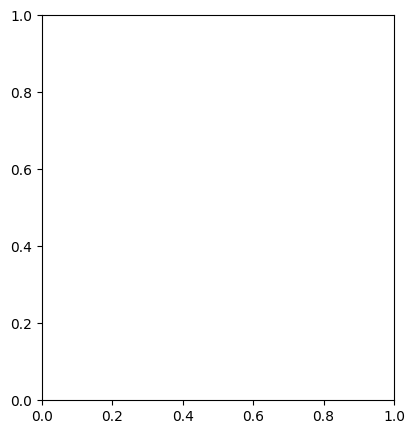

In [32]:
#print atributes of the history
print(histories[1].metrics_distributed)


#for each history, plot the accuracy and loss for each round
for i in range(len(histories)):
    